# Packages

In [68]:
# Packages
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import random
from datetime import date, datetime
from pandas.tseries.frequencies import to_offset
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_theme(style="darkgrid")
from mpl_toolkits.mplot3d import Axes3D
from tabulate import tabulate
from stargazer.stargazer import Stargazer


# import plotly.graph_objects as go
import copy
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, SVAR
import statsmodels.tsa.vector_ar.svar_model as svar
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import pearsonr
import requests as req

from fredapi import Fred
fred = Fred(api_key="ef7244731efdde9698fef5d547b7094f")

from MA_functions import *

# Pfade

In [9]:
path_ma_data = r"C:\Users\alexa\Documents\Studium\MSc (WU)\Master Thesis\Analysis\Data"
path_ma_figures = r"C:\Users\alexa\Documents\Studium\MSc (WU)\Master Thesis\Analysis"

# Data

In [70]:
# GDP
gdp_us = fred.get_series("GDPC1")
gdp_us.rename("GDP_US", inplace=True)


# Industrial Production
ind_pro_us = fred.get_series("INDPRO")
ind_pro_us.rename("INDPRO", inplace=True)

ind_pro_us_diff = ind_pro_us.pct_change(periods=12).dropna() * 100
ind_pro_us_diff.name = "INDPRO_YoY"


# CPI
cpi_us = fred.get_series("CPIAUCSL")  # convert to YoY rate
cpi_us.rename("CPI_US", inplace=True)

infl_us = cpi_us.pct_change(periods=12).dropna() * 100
infl_us.rename("Infl_US", inplace=True)


# # Investment
# inv_us = fred.get_series("GPDIC96")
# inv_us.rename("Inv_US", inplace=True)


# # Cpaital Utilization
# cap_util_us = fred.get_series("TCU")
# cap_util_us.rename("CU_US", inplace=True)

# cap_util_us_diff = cap_util_us.pct_change(periods=12).dropna() * 100
# cap_util_us_diff.name = "CU_US_YoY"


# FFR
ffr = fred.get_series("DFF")
ffr.rename("FFR", inplace=True)
ffr_m = ffr.resample("M").mean()  # convert daily to monthly!!!
ffr_m.index = ffr_m.index + pd.DateOffset(days=1)

# # T-Bill 3M
# tb_3m = fred.get_series("TB3MS")
# tb_3m.rename("TB_3M", inplace=True)


# T-Note 1Y
tb_1y = fred.get_series("DGS1")
tb_1y.rename("DGS1", inplace=True)
tb_1y_m = tb_1y.resample("M").mean()
tb_1y_m.index = tb_1y_m.index + pd.DateOffset(days=1)

# T-Bond 10Y
tb_10y = fred.get_series("DGS10")
tb_10y.rename("DGS10", inplace=True)
tb_10y_m = tb_10y.resample("M").mean()
tb_10y_m.index = tb_10y_m.index + pd.DateOffset(days=1)



# Term Spread
ts_10y3m_us = fred.get_series("T10Y3M")
ts_10y3m_us.rename("TS10Y3M_US", inplace=True)

ts_10y2y_us = fred.get_series("T10Y2Y")
ts_10y2y_us.rename("TS10Y2Y_US", inplace=True)

# y_12m = fred.get_series('TY12MCD')

# NBER Recession Dates
us_rec = fred.get_series("USREC")


# S&P 500
# sp_500_tckr = yf.Ticker('^GSPC')
# sp_500 = sp_500_tckr.history(period='max')
sp_500_1 = yf.download("^GSPC", start="1970-01-01", end="2023-01-01")
sp_500_1_m = sp_500_1["Close"].resample("M").mean()
sp_500_1_m.index = sp_500_1_m.index + pd.DateOffset(days=1)

sp_500_1_m.name = "S&P_500"

sp_500_1_m_ret = sp_500_1_m.pct_change(periods=12).dropna() * 100
sp_500_1_m_ret.name = "S&P_500_YoY"

# Financial Stress Variables
# Excess Bond Premium (EBP)
ebp = pd.read_csv(path_ma_data + "\\" + "ebp_csv.csv", index_col=[0], parse_dates=True)

[*********************100%***********************]  1 of 1 completed


### Yields Liu, Wu (2021)
(https://sites.google.com/view/jingcynthiawu/yield-data)

In [64]:
yields_us = pd.read_excel(path_ma_data + "\\" + "LW_monthly.xlsx", skiprows=8)

yields_us.rename(columns={yields_us.columns[0]: "Date"}, inplace=True)

yields_us["Date"] = pd.to_datetime(yields_us["Date"], format="%Y%m")

yields_us.set_index([yields_us.columns[0]], inplace=True)

yields_us.columns = [col.replace(" ", "") for col in yields_us.columns]

yields_us = yields_us 

# Subset Yield Data as not all maturities are available for each point in time -> used in R for Nelson-Siegel decomposition
start_yields_us = "1975-01-01"
yields_us_sub = yields_us.loc[start_yields_us:]
yields_us_sub.to_csv(path_ma_data + "\\" +  "Yields_Data_Subset.csv")

Estimated NS-Factors (in R)

<Axes: xlabel='Date'>

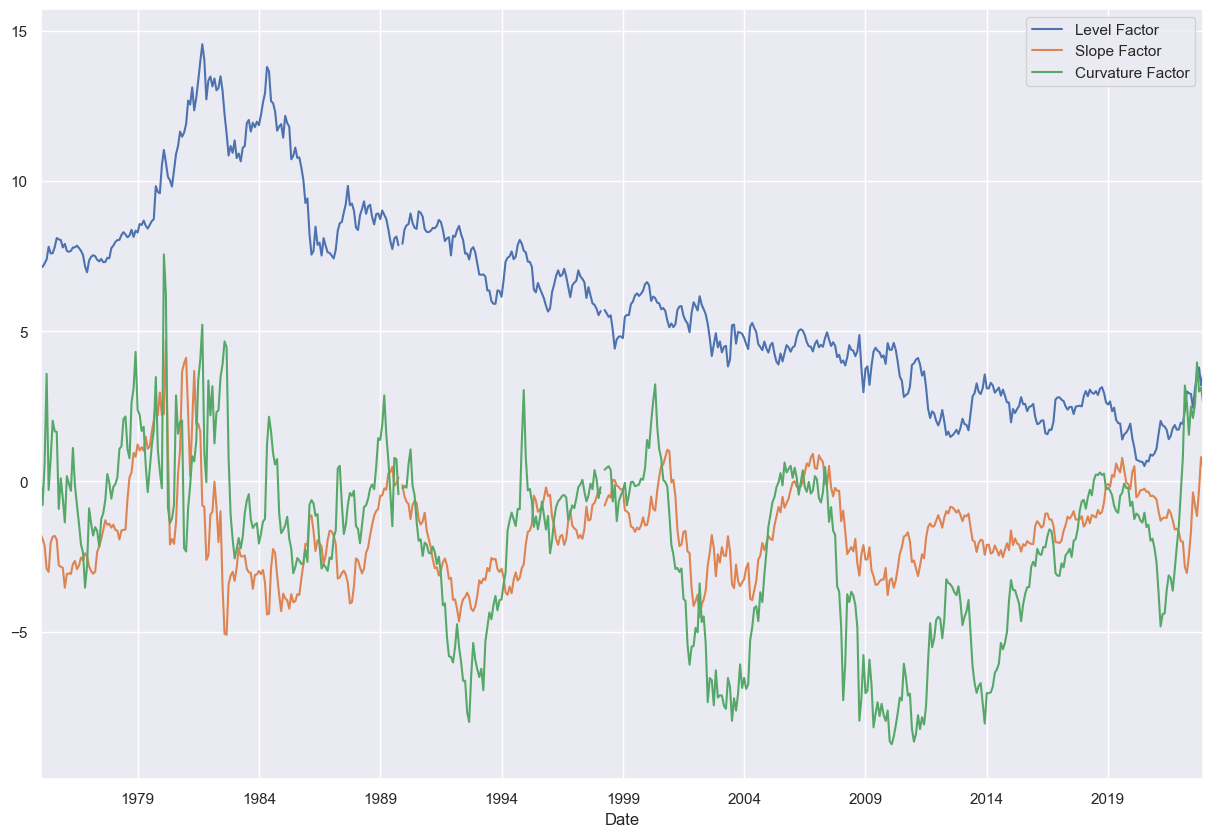

In [65]:
yields_us_sub_r = pd.read_csv(path_ma_data + "\\" + "Yields_US_R_v2.csv", index_col=[0], parse_dates=True)

yields_us_sub_r.rename(
    columns={
        "beta_0": "Level Factor",
        "beta_1": "Slope Factor",
        "beta_2": "Curvature Factor",
    },
    inplace=True,
)

yields_us_sub_r.iloc[: , -4:-1].plot(figsize=(15,10))

Yield Curve Factors Approximations

In [71]:

# Get Approximations for Coefficients (see Diebold et al. (2006))
# Beta 0 - Level Factor
yields_us_sub_r["(y(3) + y(24) + y(120))/3"] = np.nan
for t in yields_us_sub_r.index:
    result_beta_0 = get_beta_0_approx(yields_us_sub_r, t)
    yields_us_sub_r.loc[t, "(y(3) + y(24) + y(120))/3"] = result_beta_0


# Beta 1 - Slope Factor
yields_us_sub_r["y(3) - y(120)"] = yields_us_sub_r["3m"] - yields_us_sub_r["120m"]


# Beta 2 - Curvature Factor
yields_us_sub_r["2 * y(24) - y(120) - y(3)"] = (
    2 * yields_us_sub_r["24m"] - yields_us_sub_r["120m"] - yields_us_sub_r["3m"]
)

## FED Yields Data
(https://www.federalreserve.gov/data/nominal-yield-curve.htm)

In [46]:
# Data
# NBER Recession Dates
us_rec = fred.get_series("USREC")

# us_rec.loc["1970":].plot.area(color="lightgray", alpha=0.5)

# FED Yield Curva Factors
fed_factors = pd.read_csv(path_ma_data + "\\" + "feds200628.csv", 
                          skiprows=9,
                          index_col=[0])

fed_factors.index = pd.to_datetime(fed_factors.index)

# convert to monthly
fed_factors_m = fed_factors.resample("M").mean()
fed_factors_m.index = fed_factors_m.index + pd.DateOffset(days=1)

# Extract zero-coupon yields for R NS Analysis
# cols_ns_r = [col for col in fed_factors.columns if "SVENY" in col]
cols_ns_r = [
    'SVENY01', 
    'SVENY03', 
    'SVENY05', 
    'SVENY07', 
    'SVENY10',
    'SVENY15',
]

# Save data for R Analysis (NS decomposition in R)
fred_yields_r = fed_factors_m[cols_ns_r].dropna()
fred_yields_r.to_csv(path_ma_data + "\\" + "FED_Yields.csv")

<Axes: xlabel='Date'>

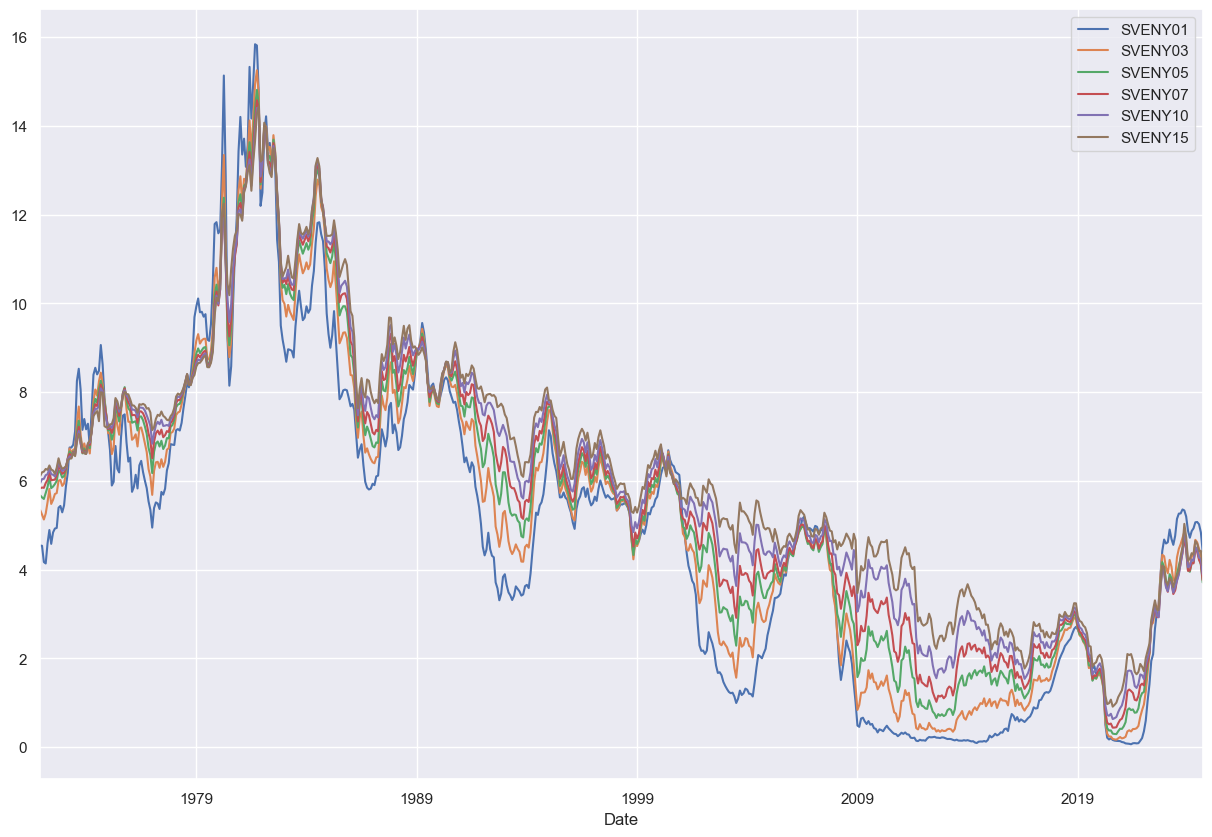

In [47]:
fred_yields_r.plot(figsize=(15,10))

Estimated Factors (in R)

<Axes: xlabel='Date'>

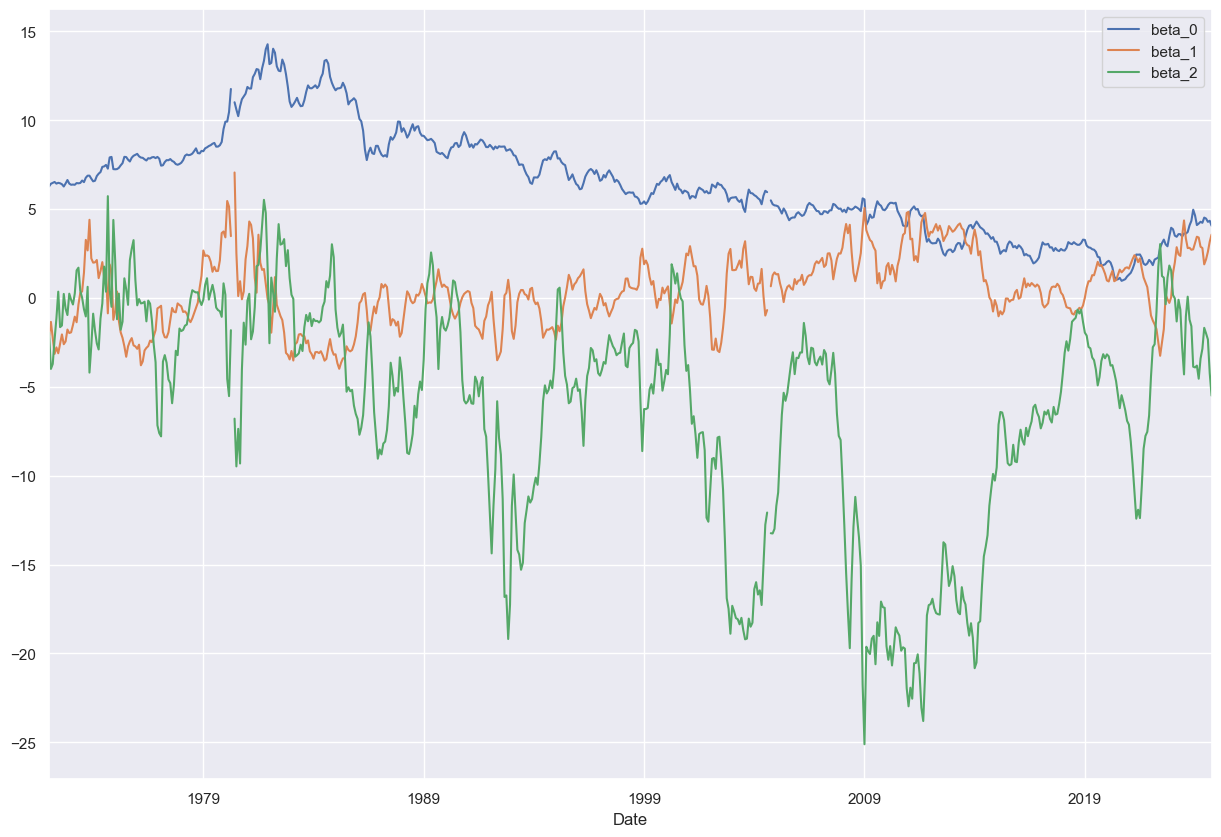

In [49]:
factors_fed_yields_r = pd.read_csv(path_ma_data + "\\" + "FED_Yields_US_R.csv",
                                   index_col=[0])
factors_fed_yields_r.index = pd.to_datetime(factors_fed_yields_r.index)


factors_fed_yields_r_m = factors_fed_yields_r.resample("M").mean()
factors_fed_yields_r_m.index = factors_fed_yields_r_m.index + pd.DateOffset(days=1)

factors_fed_yields_r_m.loc[:, ["beta_0", "beta_1", "beta_2"]].plot(figsize=(15,10))

<Axes: xlabel='Date'>

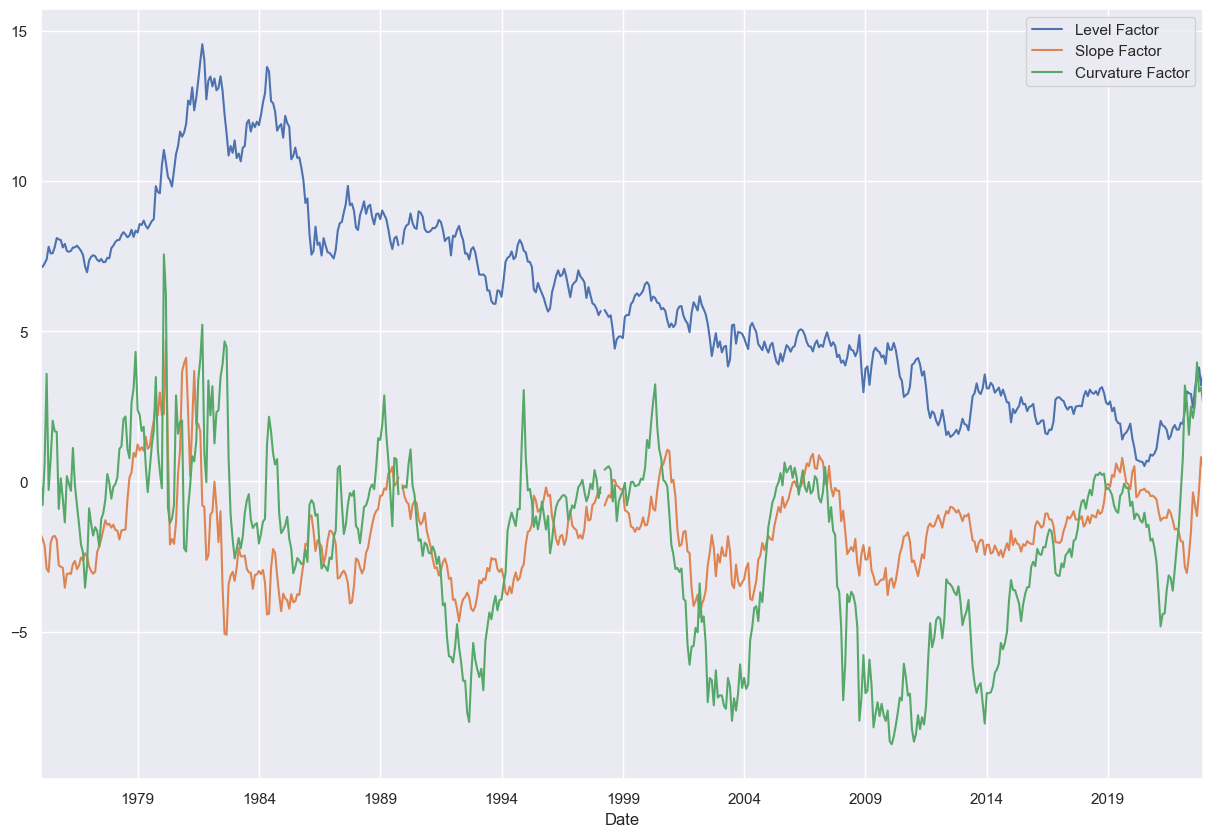

In [39]:
factors_fed_yields_r.index

DatetimeIndex(['1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01',
               ...
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01'],
              dtype='datetime64[ns]', name='Date', length=634, freq=None)

## Concat Data

In [89]:
# Columns from R output to use for merge
yield_cols_to_use = [
    "3m",
    "6m",
    "9m",
    "12m",
    "15m",
    "18m",
    "21m",
    "24m",
    "30m",
    "36m",
    "48m",
    "60m",
    "72m",
    "84m",
    "96m",
    "108m",
    "120m",
    "Level Factor",
    "Slope Factor",
    "Curvature Factor",
    "(y(3) + y(24) + y(120))/3",
    "y(3) - y(120)",
    "2 * y(24) - y(120) - y(3)",
]
# Get Period
start_us = "1975-01-01"
# start_us = max(
#     # min(gdp_us.index),
#     min(ind_pro_us.index),
#     min(ind_pro_us_diff.index),
#     min(infl_us.index),
#     min(ffr_m.index),
#     min(cap_util_us_diff.index),
#     min(yields_us_sub_r.index),
#     min(tb_3m.index),
#     min(sp_500_1_m.index),
#     min(sp_500_1_m_ret.index),
#     min(ebp["ebp"].index),
#     # min(ciss_idx.index),
#     #    min(vix_m.index),
#     #    min(ts_10y2y_us.index)
# )

# end_us = "2000-12-01"
end_us = min(
    # max(gdp_us.index),
    max(ind_pro_us.index),
    max(ind_pro_us_diff.index),
    max(infl_us.index),
    max(ffr_m.index),
    # max(cap_util_us_diff.index),
    max(yields_us_sub_r.index),
    # max(tb_3m.index),
    max(sp_500_1_m.index),
    max(sp_500_1_m_ret.index),
    max(ebp["ebp"].index),
    # max(ciss_idx.index),
    #    max(vix_m.index),
    #    max(ts_10y2y_us.index)
)


# Merge Data
df_us = [
    # gdp_us[start_us:end_us],
    # ind_pro_us[start_us:end_us],
    ind_pro_us_diff[start_us:end_us],
    # cpi_us[start_us:end_us],
    infl_us[start_us:end_us],
    ffr_m[start_us:end_us],
    # cap_util_us[start_us:end_us],
    # cap_util_us_diff[start_us:end_us],
    yields_us_sub_r.loc[start_us:end_us, yield_cols_to_use],
    # tb_3m[start_us:end_us],
    sp_500_1_m.loc[start_us:end_us],
    sp_500_1_m_ret.loc[start_us:end_us],
    ebp.loc[start_us:end_us, "ebp"],
    # ciss_idx.loc[start_us:end_us],
    #  ts_10y2y_us[start_us:end_us]
]

df_us = pd.concat(df_us, axis=1).dropna()

# Plots

NBER Recession Months

In [90]:
# Add shadded Recession Areas in Figures for Sample Period
us_rec = us_rec.loc[start_us:end_us]

### Factor Figure

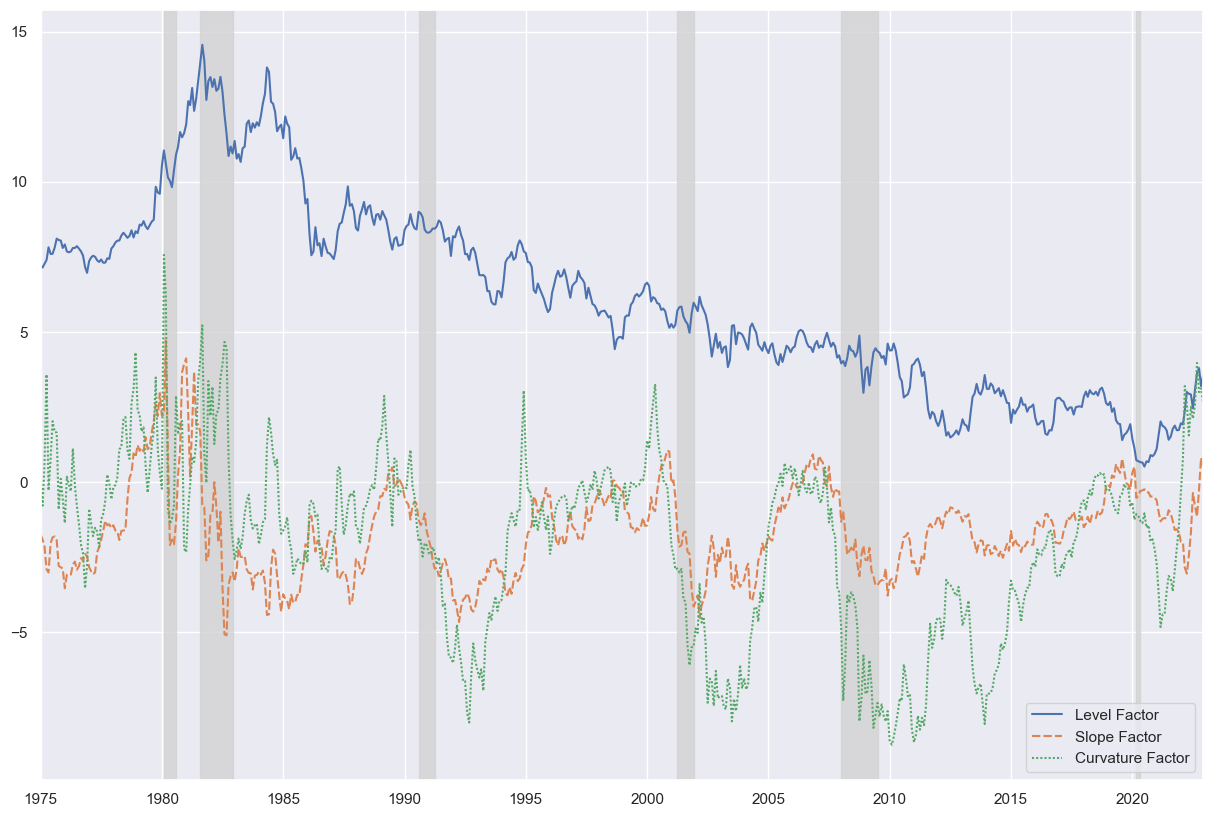

In [94]:
plt.figure(figsize=(15, 10))
sns.lineplot(df_us[["Level Factor", "Slope Factor", "Curvature Factor"]])
plt.legend(loc="lower right")

# Automatically set the x-axis limits to include all values, starting and stopping at the first and last index
plt.xlim(df_us.index[0], df_us.index[-1])

# Ensure the x-axis ticks start and stop exactly at df_us.index[0] and df_us.index[-1]
# plt.xticks([df_us.index[0], df_us.index[-1]], labels=[df_us.index[0], df_us.index[-1]])


# Adding recession bars
start_date = None  # Initialize start_date to None
for i in range(1, len(us_rec)):
    if us_rec.iloc[i] == 1 and us_rec.iloc[i - 1] == 0:
        start_date = us_rec.index[i]
    if us_rec.iloc[i] == 0 and us_rec.iloc[i - 1] == 1:
        end_date = us_rec.index[i]
        plt.axvspan(start_date, end_date, color="lightgray", alpha=0.8)
        start_date = None  # Reset start_date after plotting

# Handle the case where the series ends in a recession
if start_date is not None:
    plt.axvspan(start_date, ind_pro_us_diff.index[-1], color="lightgray", alpha=0.8)

plt.savefig(path_ma_figures + "\\" + "Factor_Figure.pdf", dpi=1000)
plt.show()

### Level Factor and Inflation

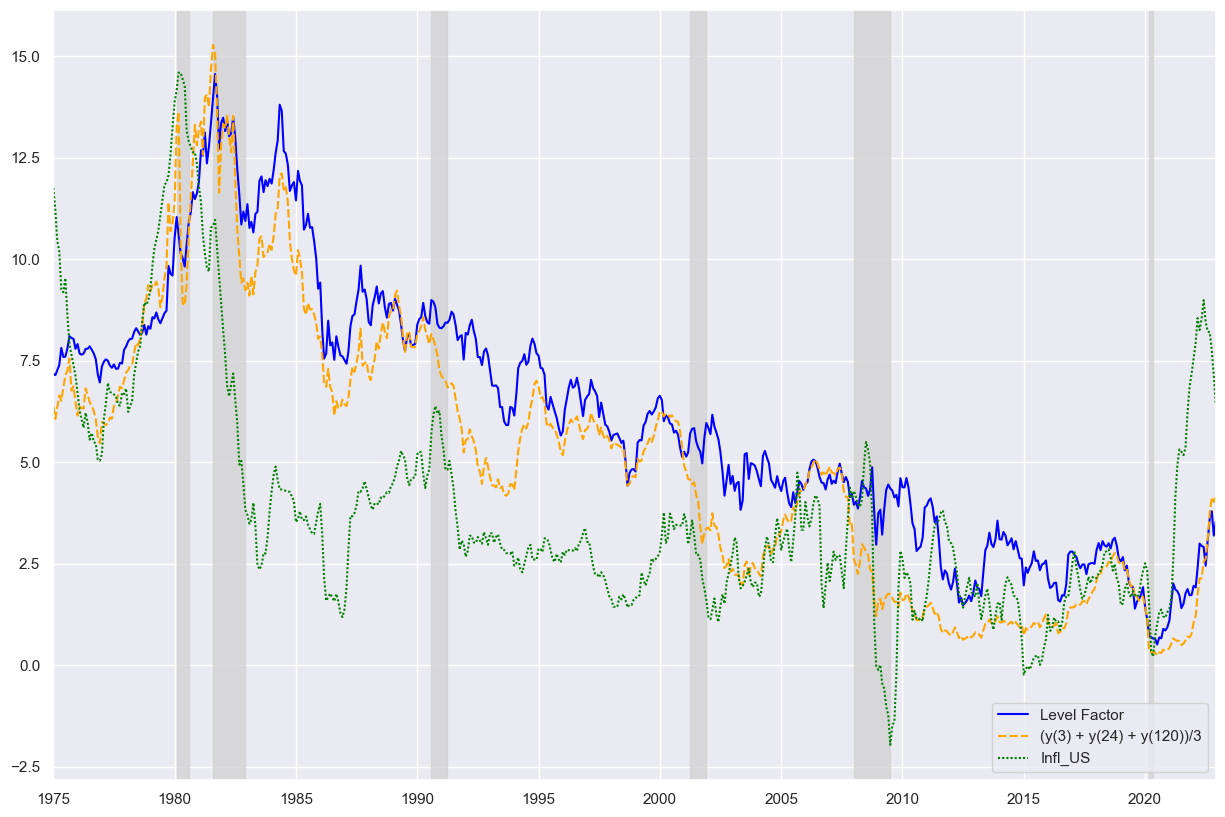

In [95]:
# Beta 0 Level Factor & Inflation
plt.figure(figsize=(15, 10))
sns.lineplot(
    df_us[["Level Factor", "(y(3) + y(24) + y(120))/3", "Infl_US"]],
    legend="auto",
    palette=["blue", "orange", "green"],
)
plt.legend(loc="lower right")

# Set the x-axis limits to start and stop where the data starts and stops
plt.xlim(df_us.index[0], df_us.index[-1])  # Set x-axis limits dynamically based on data

# Adding recession bars
start_date = None  # Initialize start_date to None
for i in range(1, len(us_rec)):
    if us_rec.iloc[i] == 1 and us_rec.iloc[i - 1] == 0:
        start_date = us_rec.index[i]
    if us_rec.iloc[i] == 0 and us_rec.iloc[i - 1] == 1:
        end_date = us_rec.index[i]
        plt.axvspan(start_date, end_date, color="lightgray", alpha=0.8)
        start_date = None  # Reset start_date after plotting

# Handle the case where the series ends in a recession
if start_date is not None:
    plt.axvspan(start_date, ind_pro_us_diff.index[-1], color="lightgray", alpha=0.8)

plt.savefig(path_ma_figures + "\\" + "Beta_0_Figure.pdf", dpi=1000)
plt.show()


### Slope Factor and Industrial Production

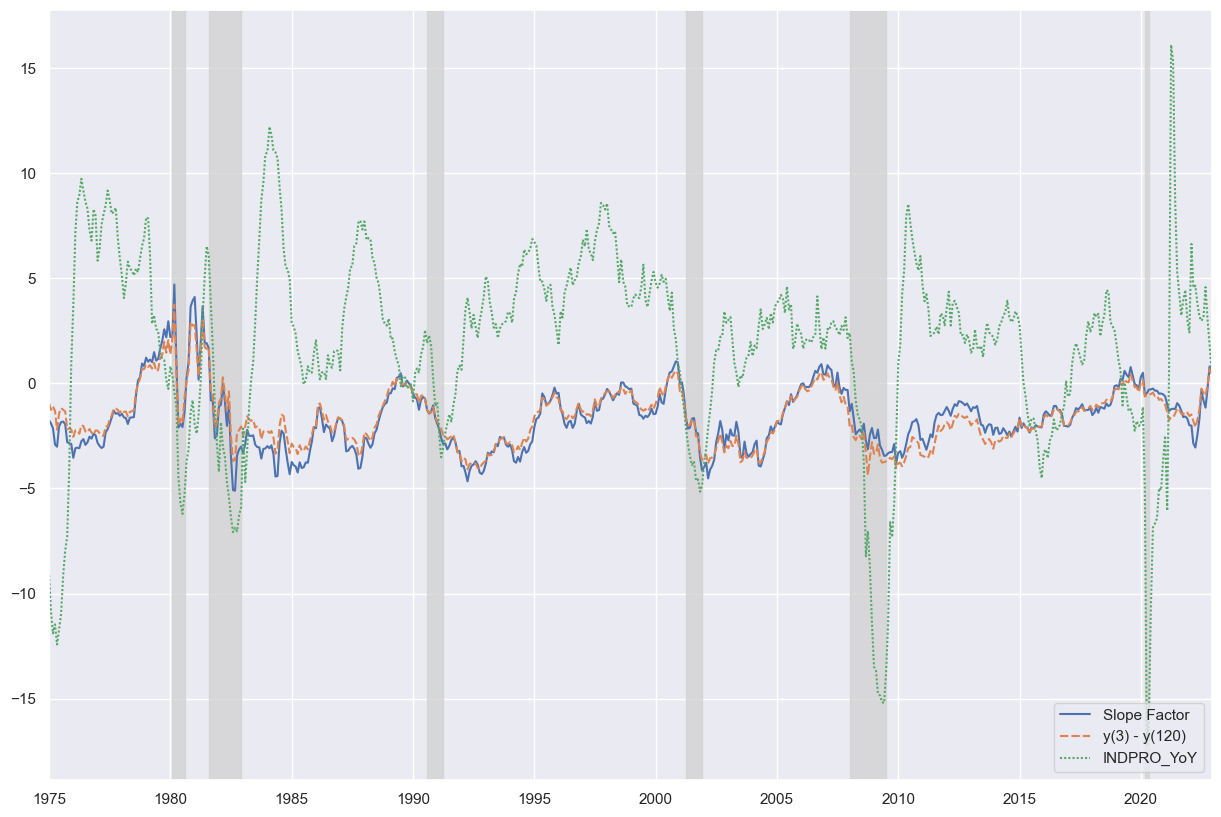

In [96]:
# Beta 1 Slope Factor
plt.figure(figsize=(15, 10))
sns.lineplot(df_us[["Slope Factor", "y(3) - y(120)", "INDPRO_YoY"]])
plt.legend(loc="lower right")

# Set the x-axis limits to start and stop where the data starts and stops
plt.xlim(df_us.index[0], df_us.index[-1])  # Set x-axis limits dynamically based on data

# Adding recession bars
start_date = None  # Initialize start_date to None
for i in range(1, len(us_rec)):
    if us_rec.iloc[i] == 1 and us_rec.iloc[i - 1] == 0:
        start_date = us_rec.index[i]
    if us_rec.iloc[i] == 0 and us_rec.iloc[i - 1] == 1:
        end_date = us_rec.index[i]
        plt.axvspan(start_date, end_date, color="lightgray", alpha=0.8)
        start_date = None  # Reset start_date after plotting

# Handle the case where the series ends in a recession
if start_date is not None:
    plt.axvspan(start_date, ind_pro_us_diff.index[-1], color="lightgray", alpha=0.8)

plt.savefig(path_ma_figures + "\\" + "Beta_1_Figure.pdf", dpi=1000)
plt.show()

### Curvature Factor

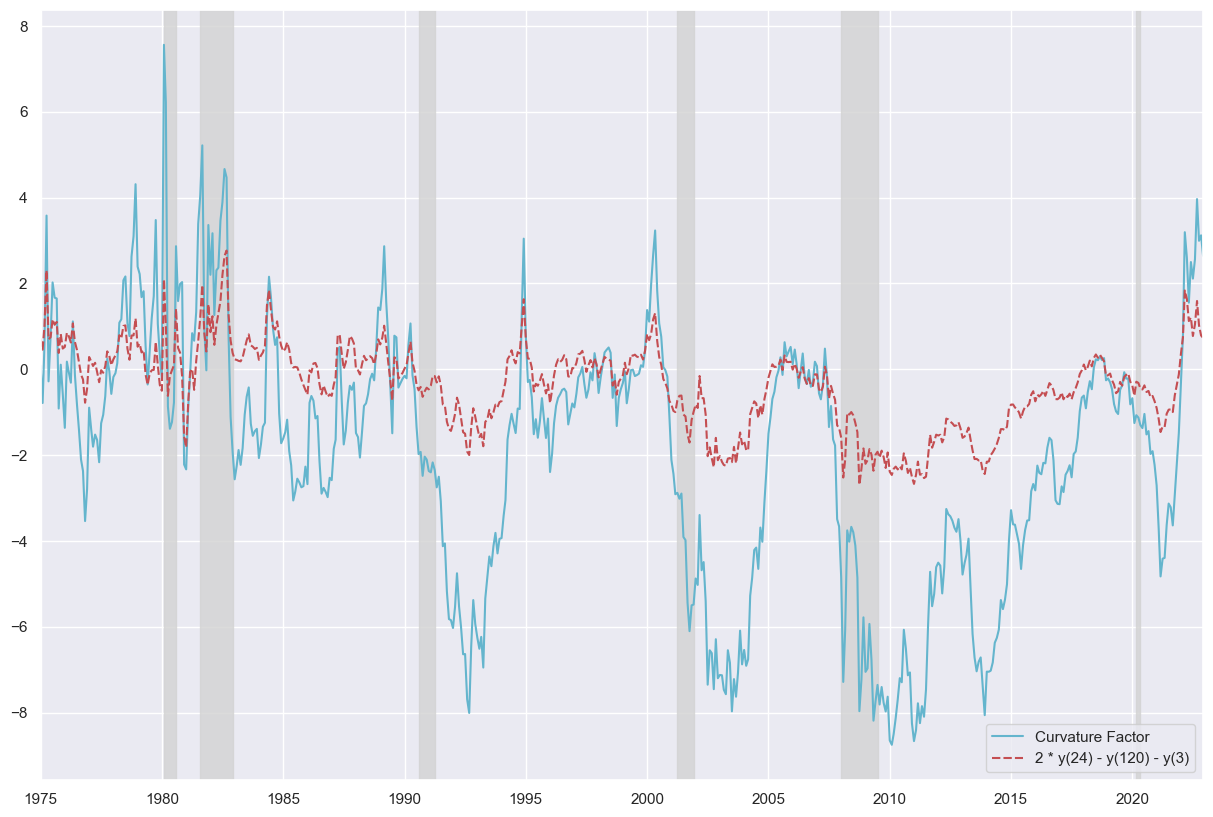

In [97]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    df_us[["Curvature Factor", "2 * y(24) - y(120) - y(3)"]], palette=["c", "r"]
)
plt.legend(loc="lower right")

# Set the x-axis limits to start and stop where the data starts and stops
plt.xlim(df_us.index[0], df_us.index[-1])  # Set x-axis limits dynamically based on data

# Adding recession bars
start_date = None  # Initialize start_date to None
for i in range(1, len(us_rec)):
    if us_rec.iloc[i] == 1 and us_rec.iloc[i - 1] == 0:
        start_date = us_rec.index[i]
    if us_rec.iloc[i] == 0 and us_rec.iloc[i - 1] == 1:
        end_date = us_rec.index[i]
        plt.axvspan(start_date, end_date, color="lightgray", alpha=0.8)
        start_date = None  # Reset start_date after plotting

# Handle the case where the series ends in a recession
if start_date is not None:
    plt.axvspan(start_date, ind_pro_us_diff.index[-1], color="lightgray", alpha=0.8)

plt.savefig(path_ma_figures + "\\" + "Beta_2_Figure.pdf", dpi=1000)
plt.show()

Correlations NS-Factors and Approximations

In [102]:
df_us["Level Factor"].corr(df_us["(y(3) + y(24) + y(120))/3"])

0.960855305514921

In [103]:
df_us["Level Factor"].corr(df_us["Infl_US"])

0.5475262016417854

In [104]:
df_us["Slope Factor"].corr(df_us["y(3) - y(120)"])

0.9516022171164868

In [105]:
df_us["Slope Factor"].corr(df_us["INDPRO_YoY"])

-0.006397694234831022

In [109]:
df_us["Curvature Factor"].corr(df_us["2 * y(24) - y(120) - y(3)"])

0.9345659422471282

In [110]:
df_us["Slope Factor"].corr(df_us["Curvature Factor"])

0.475198442143373

In [108]:
pearsonr(df_us["INDPRO_YoY"], df_us["Slope Factor"])

PearsonRResult(statistic=-0.006397694234831032, pvalue=0.8784414148210317)

## Plots Factor Loadings

C:\Users\alexa\AppData\Local\Temp\ipykernel_18776\3500723618.py:3: RuntimeWarning: invalid value encountered in scalar divide
  result = (1 - np.exp(-lmda * maturity)) / (lmda * maturity)
C:\Users\alexa\AppData\Local\Temp\ipykernel_18776\3500723618.py:9: RuntimeWarning: invalid value encountered in scalar divide
  result = (1 - np.exp(-lmda * maturity)) / (lmda * maturity) - np.exp(


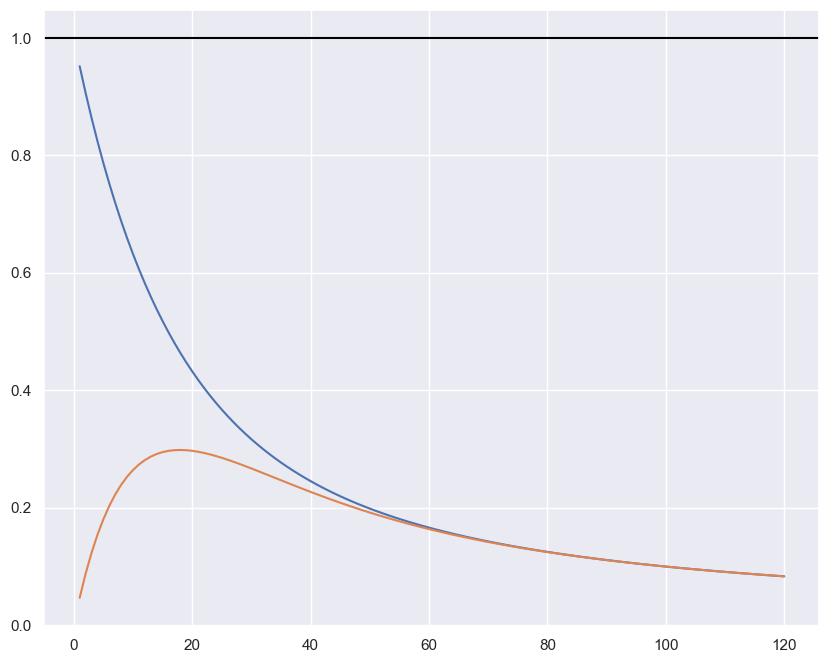

In [66]:
maturities = [mat for mat in range(0, 121)]

lmda = 0.1

dict_beta_1_loading = {}
dict_beta_2_loading = {}

for mat in maturities:
    result_1 = beta_1_loading(lmda=lmda, maturity=mat)
    dict_beta_1_loading[mat] = result_1
    
    result_2 = beta_2_loading(lmda=lmda, maturity=mat)
    dict_beta_2_loading[mat] = result_2
    


# Plot Loadings
plt.figure(figsize=(10, 8))

plt.axhline(y=1, color="black", label="Level Factor Loading")
plt.plot(
    list(dict_beta_1_loading.keys()),
    list(dict_beta_1_loading.values()),
    label="Slope Factor Loading",
)
plt.plot(
    list(dict_beta_2_loading.keys()),
    list(dict_beta_2_loading.values()),
    label="Curvature Factor Loading",
)




### ChatGPT 

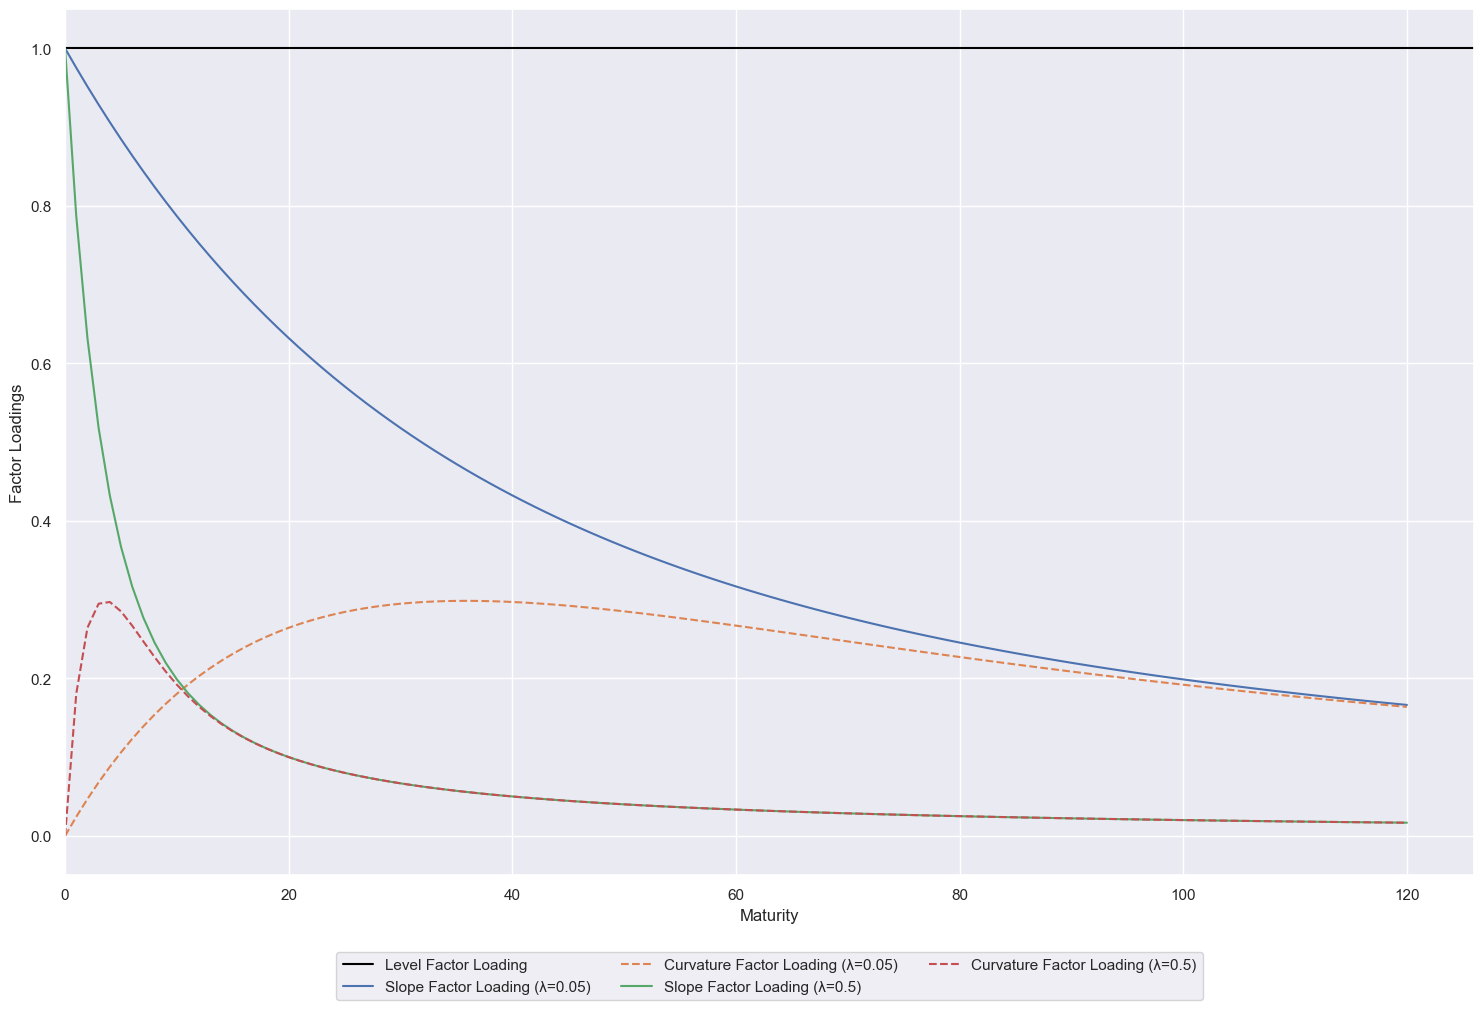

In [67]:
# List of maturities
maturities = [mat for mat in range(0, 121)]

# List of lambda values you want to use
lambdas = [0.05, 0.5]  # Add more lambda values if needed

# Create dictionaries to store the loadings for each lambda
dict_beta_1_loading = {lmda: {} for lmda in lambdas}
dict_beta_2_loading = {lmda: {} for lmda in lambdas}


# Insert value 1/0 for maturity 0 for all lambdas in both dict_beta_1_loading and dict_beta_2_loading
for lmda in lambdas:
    dict_beta_1_loading[lmda][0] = 1
    dict_beta_2_loading[lmda][0] = 0

# Loop over lambdas and maturities to calculate the loadings
for lmda in lambdas:
    for mat in maturities[1:]:  # Skip maturity 0 since we already set it
        result_1 = beta_1_loading(lmda=lmda, maturity=mat)
        dict_beta_1_loading[lmda][mat] = result_1

        result_2 = beta_2_loading(lmda=lmda, maturity=mat)
        dict_beta_2_loading[lmda][mat] = result_2
        
        
        
# Plot Loadings
plt.figure(figsize=(15, 10))

# Level factor loading line
plt.axhline(y=1, color="black", label="Level Factor Loading")

# Loop over lambdas and plot each one dynamically
for lmda in lambdas:
    plt.plot(
        list(dict_beta_1_loading[lmda].keys()),
        list(dict_beta_1_loading[lmda].values()),
        label=f"Slope Factor Loading (λ={lmda})",
    )
    plt.plot(
        list(dict_beta_2_loading[lmda].keys()),
        list(dict_beta_2_loading[lmda].values()),
        label=f"Curvature Factor Loading (λ={lmda})",
        linestyle="--",
    )

# x-axis starts at 0
plt.xlim(left=0)
# Add legend centrally below the x-axis
plt.legend()
plt.xlabel("Maturity")
plt.ylabel("Factor Loadings")
# plt.title("Factor Loadings for Different Lambda Values")

# Adjust layout to make space for the legend before saving
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add legend centrally below the x-axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=3)

plt.savefig(path_ma_figures + "\\" + "Factor_Loadings_Lambdas.pdf", bbox_inches="tight", dpi=1000)

plt.show()


Some other stuff 

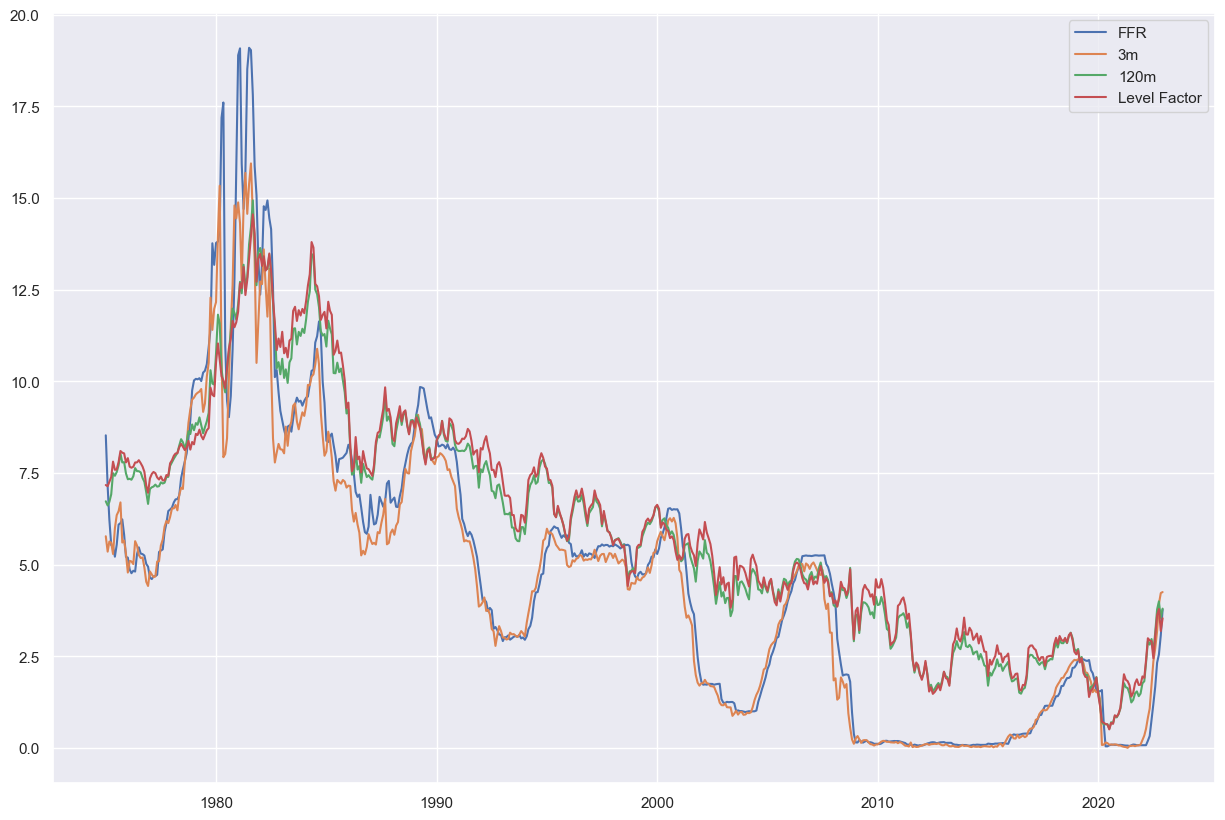

In [98]:
# Interest Rate and Yield
plt.figure(figsize=(15, 10))
plt.plot(df_us["FFR"], label="FFR")
plt.plot(df_us["3m"], label="3m")
plt.plot(df_us["120m"], label="120m")
plt.plot(df_us["Level Factor"], label="Level Factor")

plt.legend()
plt.show()

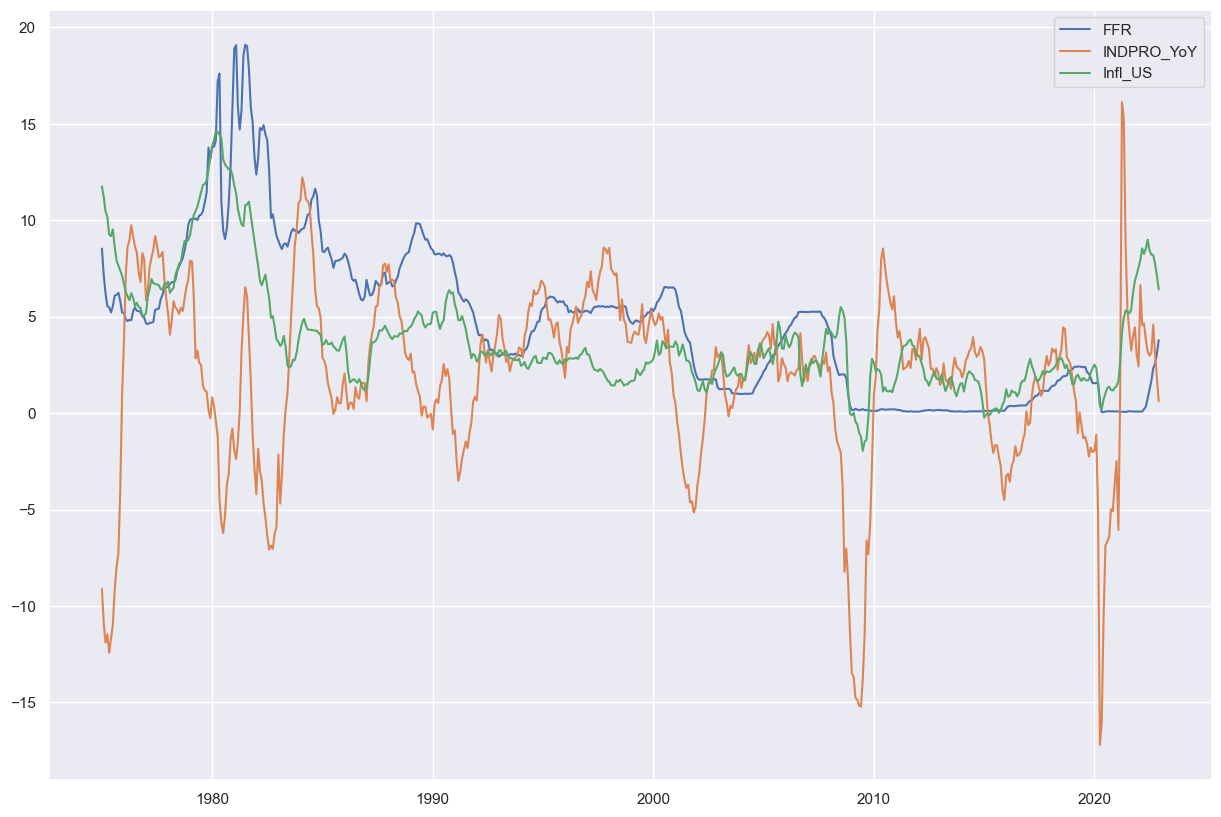

In [99]:
# IP, Inflation, FFR
plt.figure(figsize=(15, 10))
plt.plot(df_us["FFR"], label="FFR")
plt.plot(df_us["INDPRO_YoY"], label="INDPRO_YoY")
plt.plot(df_us["Infl_US"], label="Infl_US")


plt.legend()
plt.show()

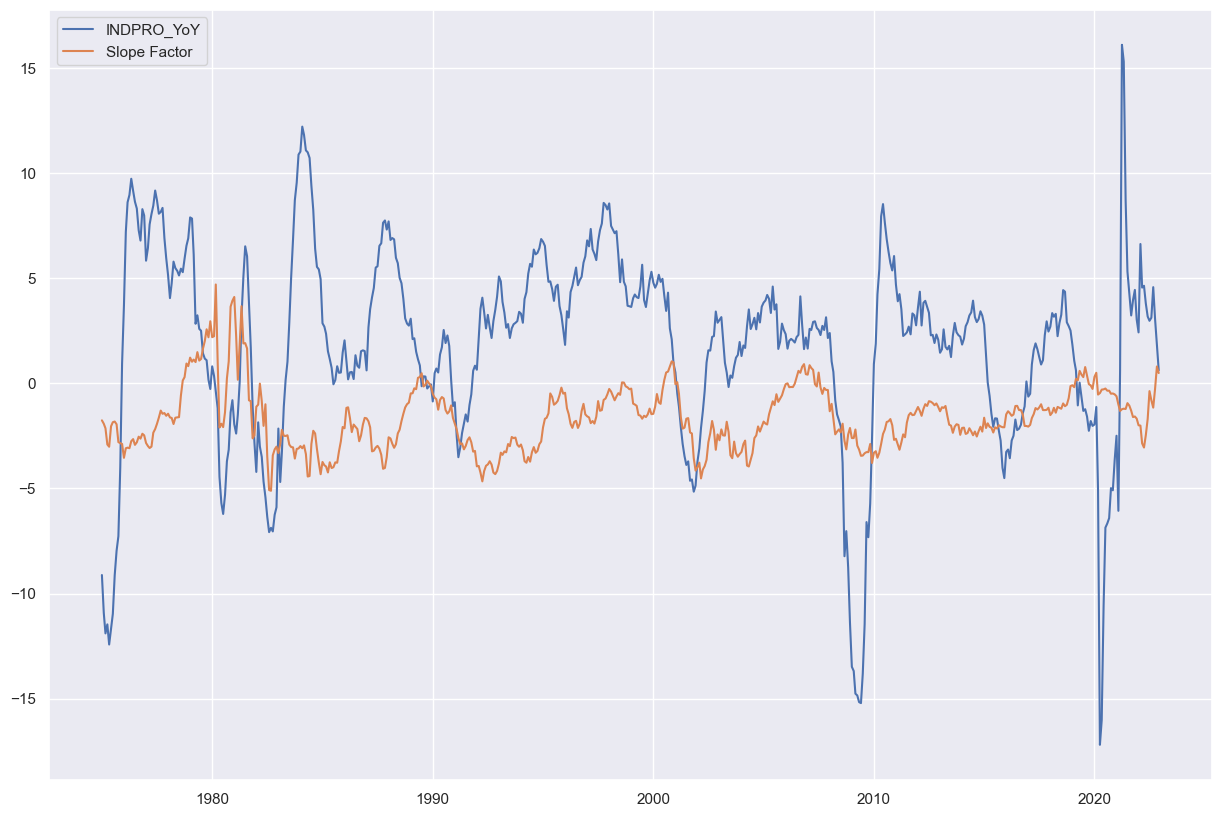

In [100]:
# IP, Slope
plt.figure(figsize=(15, 10))
plt.plot(df_us["INDPRO_YoY"], label="INDPRO_YoY")
plt.plot(df_us["Slope Factor"], label="Slope Factor")


plt.legend()
plt.show()

# Analysis

In [115]:
df_analysis_us = [
    df_us["INDPRO_YoY"],
    df_us["Infl_US"],
    df_us["FFR"],
    df_us["ebp"],
    df_us["Level Factor"],
    df_us["Slope Factor"],
    df_us["Curvature Factor"],
    df_us["S&P_500_YoY"],
]


df_analysis_us = pd.concat(df_analysis_us, axis=1)

df_analysis_us.rename(
    columns={
        "INDPRO_YoY": "IP_US",
        "ebp": "FS_US",
        "Level Factor": "L_US",
        "Slope Factor": "S_US",
        "Curvature Factor": "C_US",
        "S&P_500_YoY": "S&P_500",
    },
    inplace=True,
)

In [116]:
df_analysis_us

IP_US    Infl_US       FFR     FS_US      L_US      S_US  \
1975-01-01  -9.120686  11.752137  8.530968  0.399618  7.175468 -1.757096   
1975-02-01 -10.923374  11.205074  7.131613  0.409166  7.143674 -1.918135   
1975-03-01 -11.898245  10.460251  6.240714  0.597576  7.259008 -2.136097   
1975-04-01 -11.469932  10.187110  5.537419  0.237936  7.392024 -2.906761   
1975-05-01 -12.427782   9.259259  5.492667  0.350881  7.814367 -3.013557   
...               ...        ...       ...       ...       ...       ...   
2022-08-01   3.127811   8.218806  1.675806 -0.045597  3.071287 -0.802230   
2022-09-01   4.583138   8.198272  2.330000  0.025987  3.623084 -1.152594   
2022-10-01   3.079094   7.751941  2.555000  0.075887  3.794020 -0.268352   
2022-11-01   1.814386   7.119466  3.080000 -0.251366  3.193419  0.809684   
2022-12-01   0.624340   6.411498  3.780000 -0.037528  3.540023  0.494797   

                C_US    S&P_500  
1975-01-01  0.081951 -29.235595  
1975-02-01 -0.787170 -24.498917  
1975-03-01  0.586197 -14.291991  
1975-04-01  3.580160 -13.964677  
1975-05-01 -0.282695  -8.363971  
...              ...        ...  
2022-08-01  2.563801 -10.357769  
2022-09-01  3.964312  -6.632355  
2022-10-01  2.992407 -13.384704  
2022-11-01  3.120677 -16.469499  
2022-12-01  2.643510 -16.066765  

[574 rows x 8 columns]

## Augmented Dickey-Fuller Test

In [117]:
# Stationarity Check (with Latex output)
adf_test_us = get_adf(df_analysis_us)

col_names_adf = ["t-Statistic", "Critical value", "p-value"]

df_adf_us = pd.DataFrame.from_dict(adf_test_us, orient="index", columns=col_names_adf)

df_adf_us.index = [
    "$IP^{US}_{t}$",
    "$\\pi^{US}_{t}$",
    "$i^{US}_{t}$",
    "$FS^{US}_{t}$",
    "$L^{US}_{t}$",
    "$S^{US}_{t}$",
    "$C^{US}_{t}$",
    "$M^{US}_{t}$",
]


print(df_adf_us.round(4).to_latex(escape=False))

\begin{tabular}{lrrr}
\toprule
{} &  t-Statistic &  Critical value &  p-value \\
\midrule
$IP^{US}_{t}$  &      -4.6953 &         -2.8667 &   0.0001 \\
$\pi^{US}_{t}$ &      -2.5250 &         -2.8667 &   0.1095 \\
$i^{US}_{t}$   &      -2.2901 &         -2.8667 &   0.1752 \\
$FS^{US}_{t}$  &      -4.0692 &         -2.8668 &   0.0011 \\
$L^{US}_{t}$   &      -1.0909 &         -2.8666 &   0.7187 \\
$S^{US}_{t}$   &      -4.2902 &         -2.8668 &   0.0005 \\
$C^{US}_{t}$   &      -2.8654 &         -2.8666 &   0.0495 \\
$M^{US}_{t}$   &      -4.3833 &         -2.8667 &   0.0003 \\
\bottomrule
\end{tabular}



C:\Users\alexa\AppData\Local\Temp\ipykernel_18776\383613615.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_adf_us.round(4).to_latex(escape=False))


## Estimate sVAR

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Figure IRF_US_lag_1.pdf has been saved!


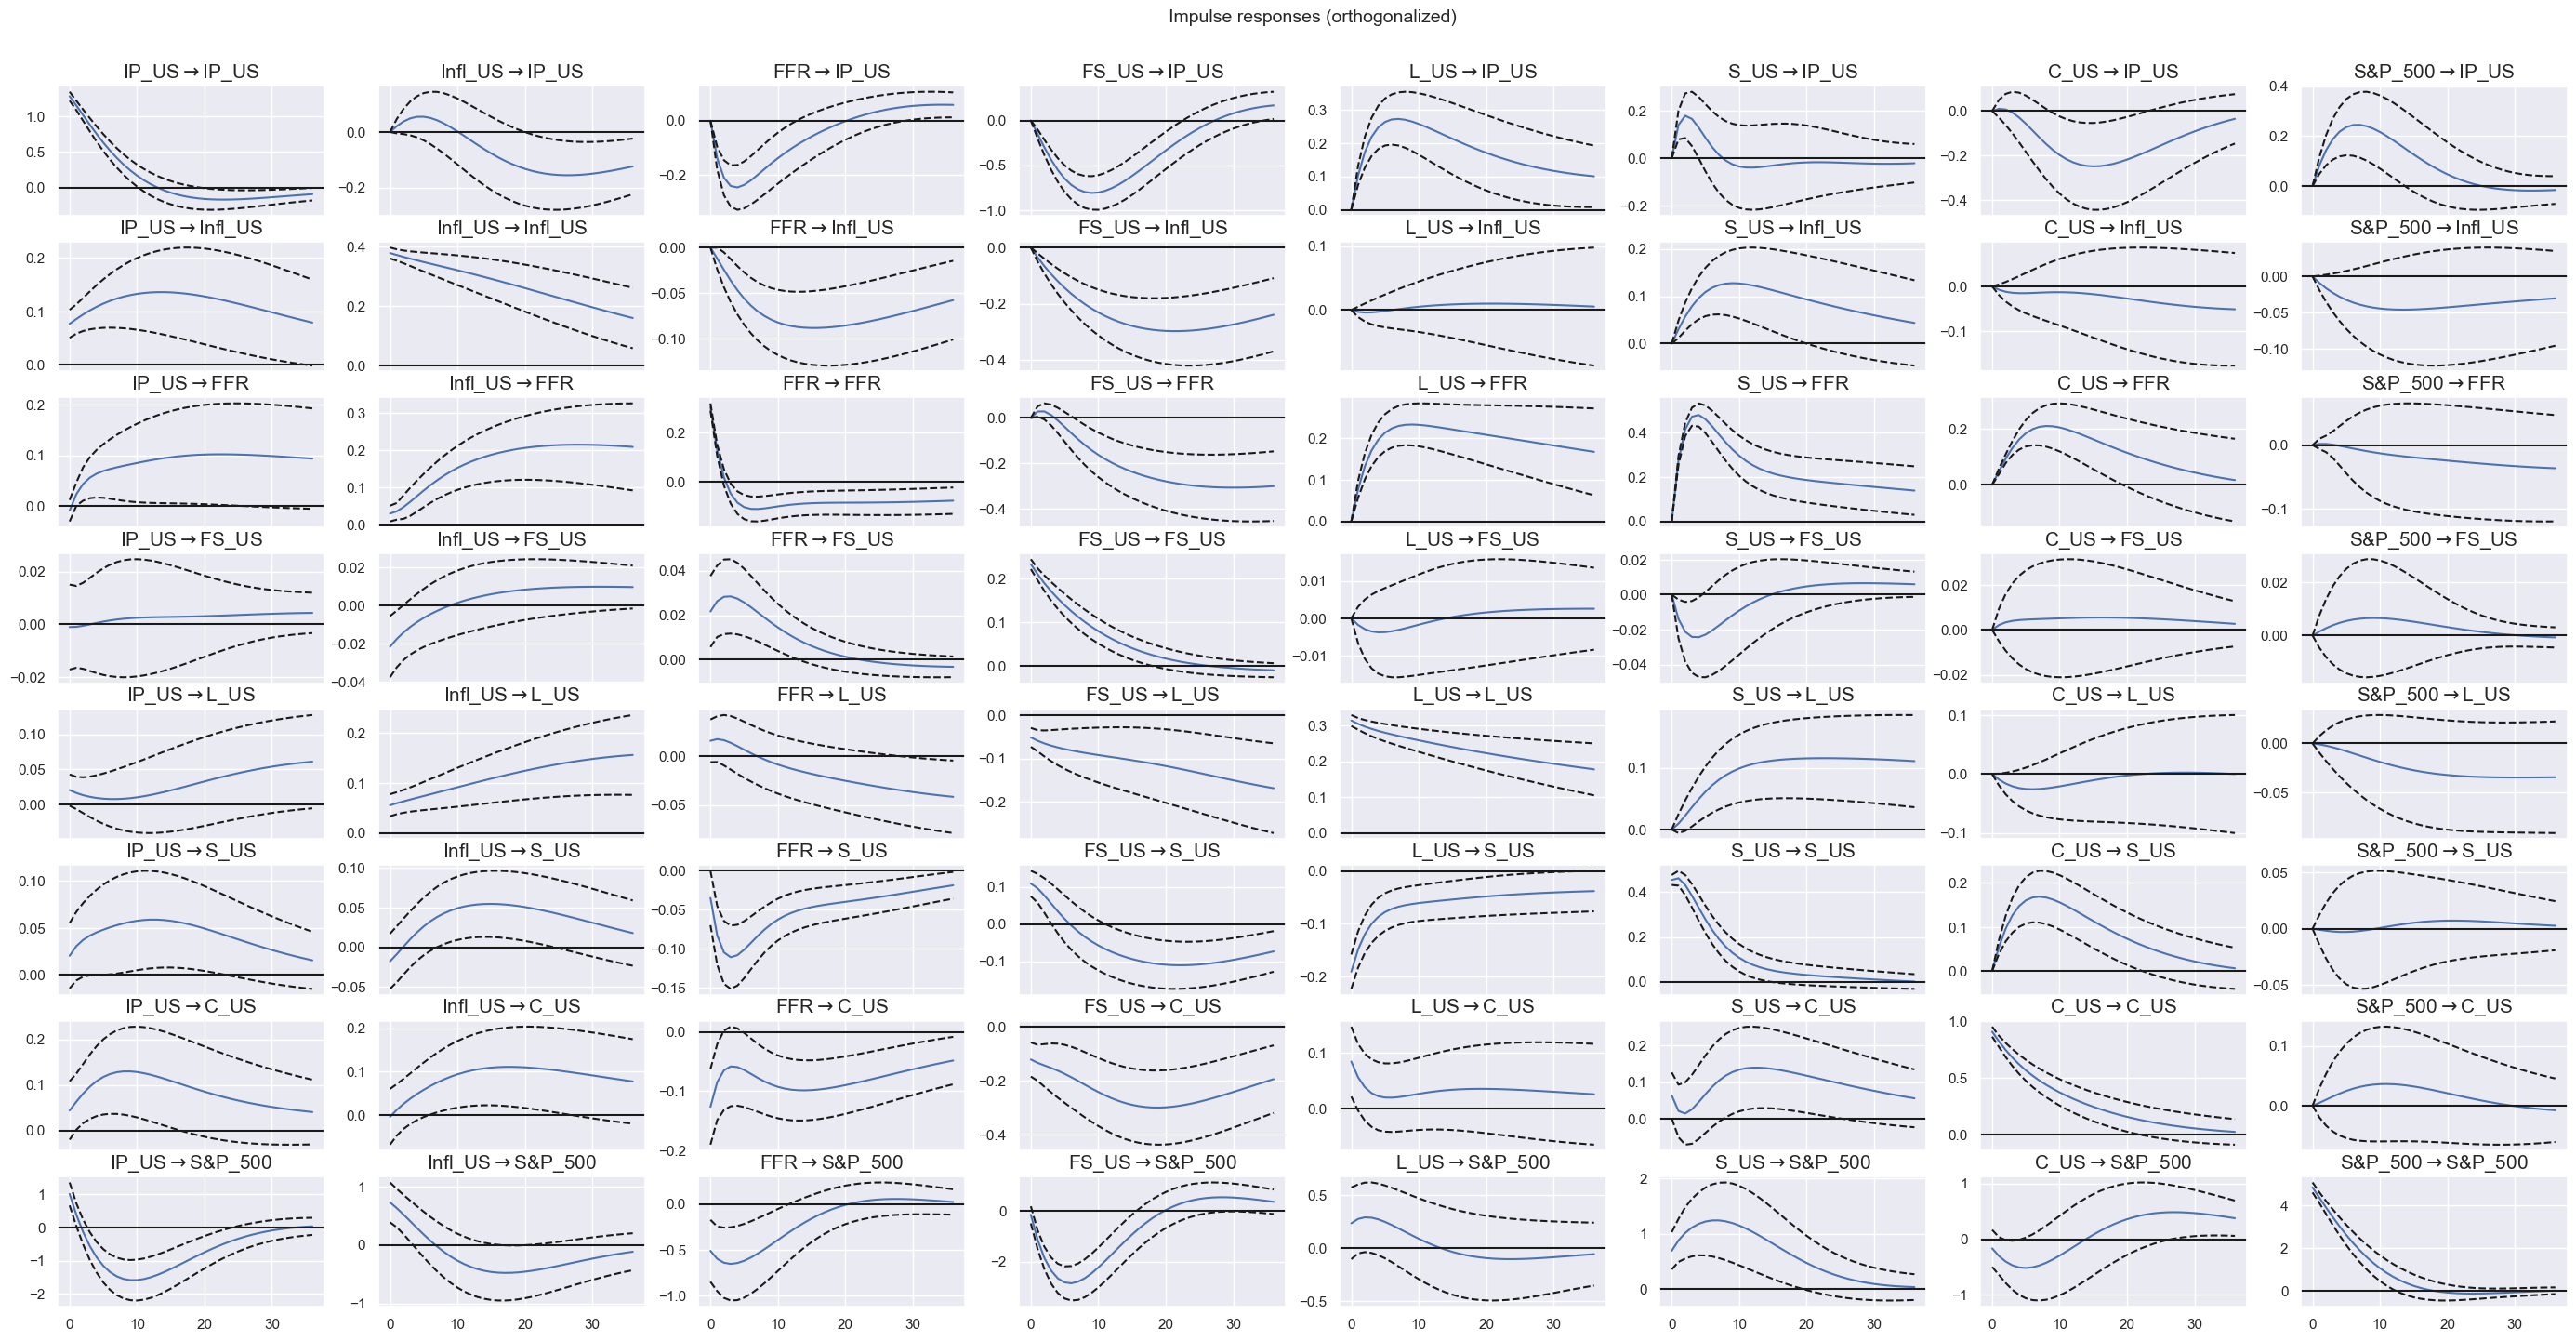

Figure IRF_US_lag_2.pdf has been saved!


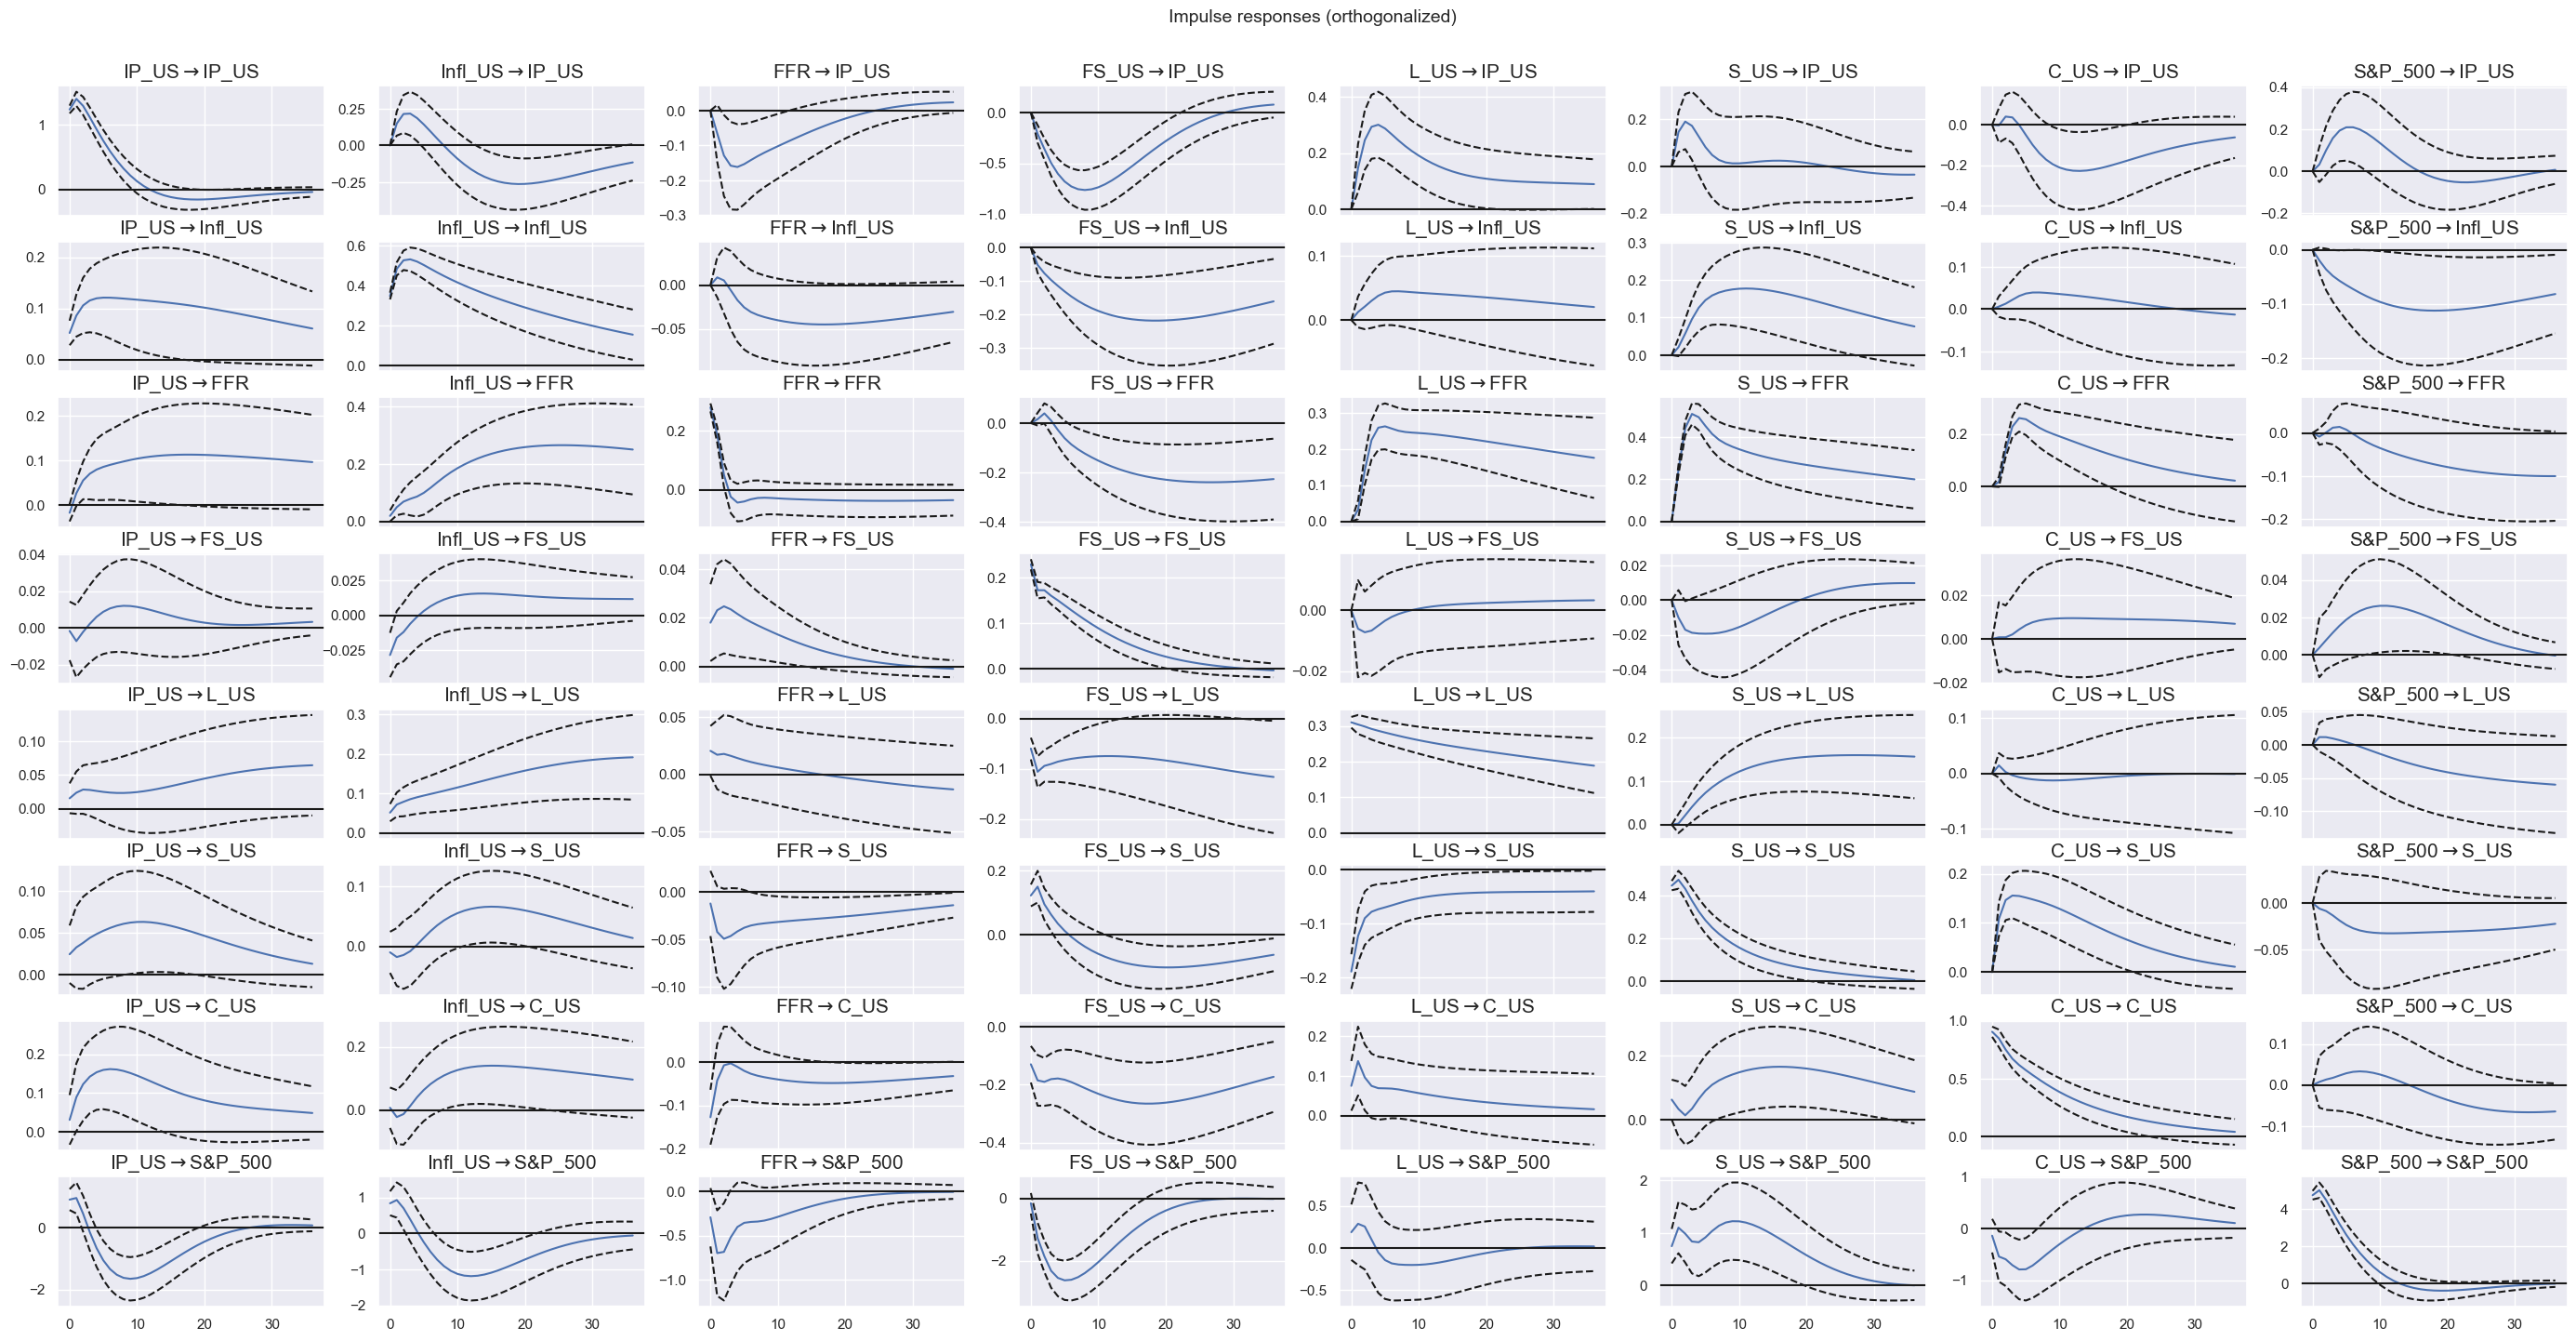

Figure IRF_US_lag_3.pdf has been saved!


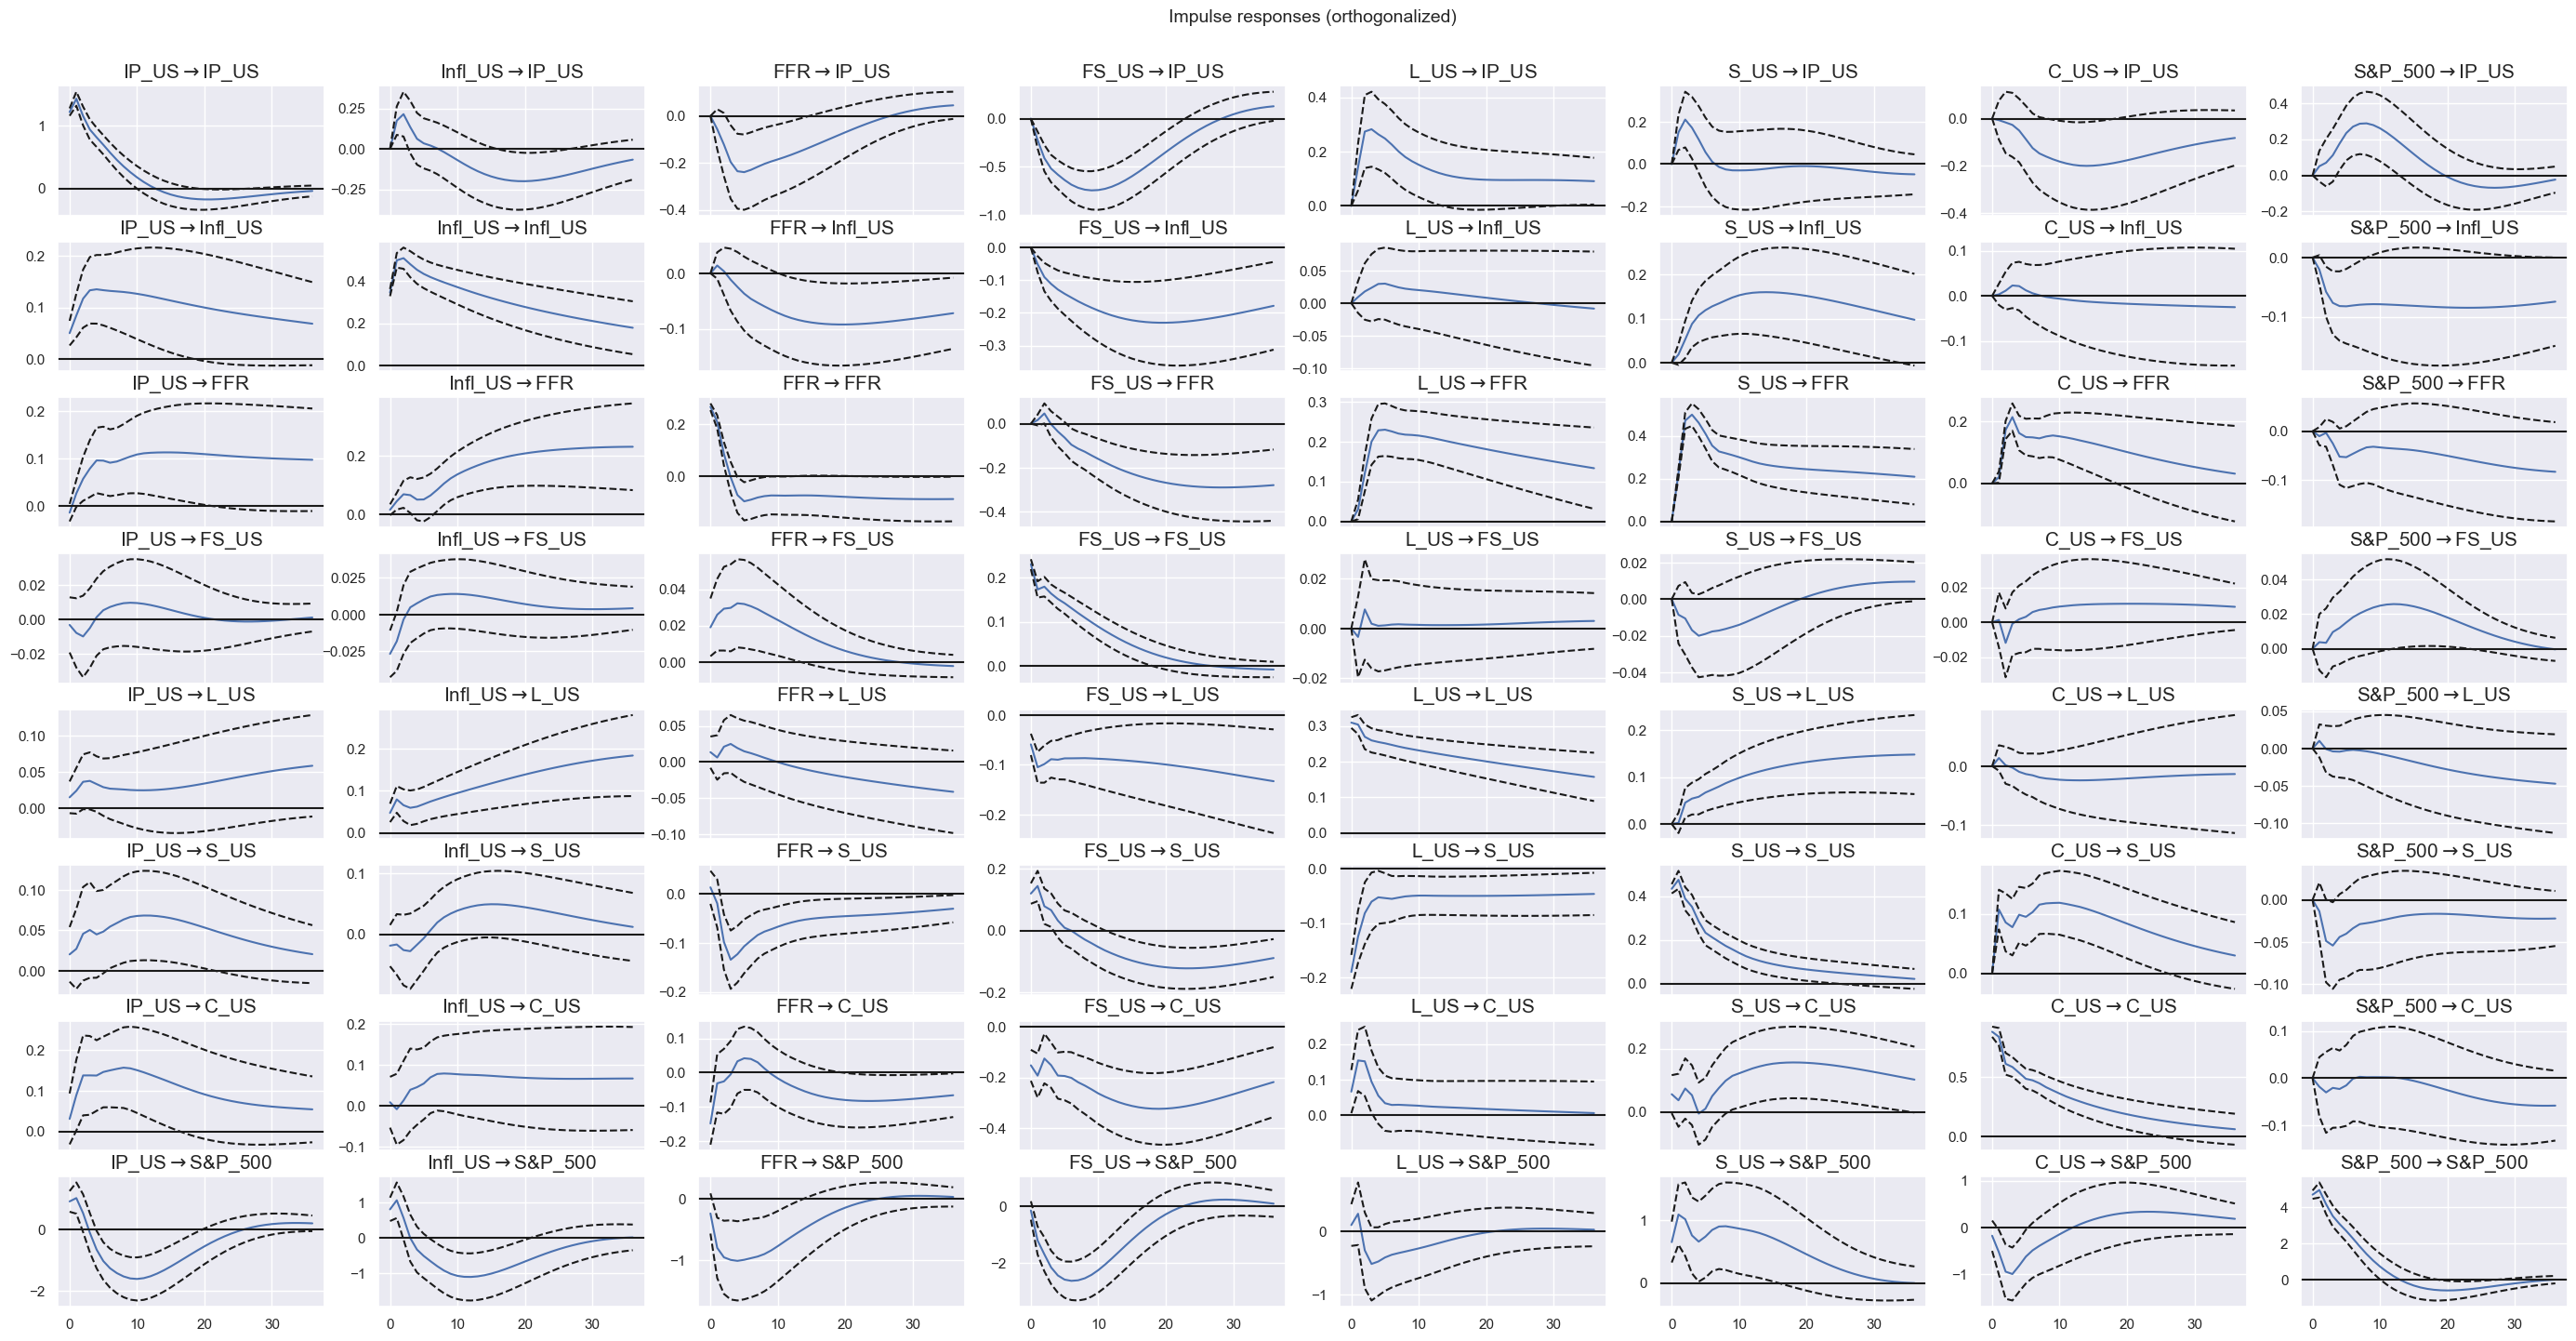

Figure IRF_US_lag_4.pdf has been saved!


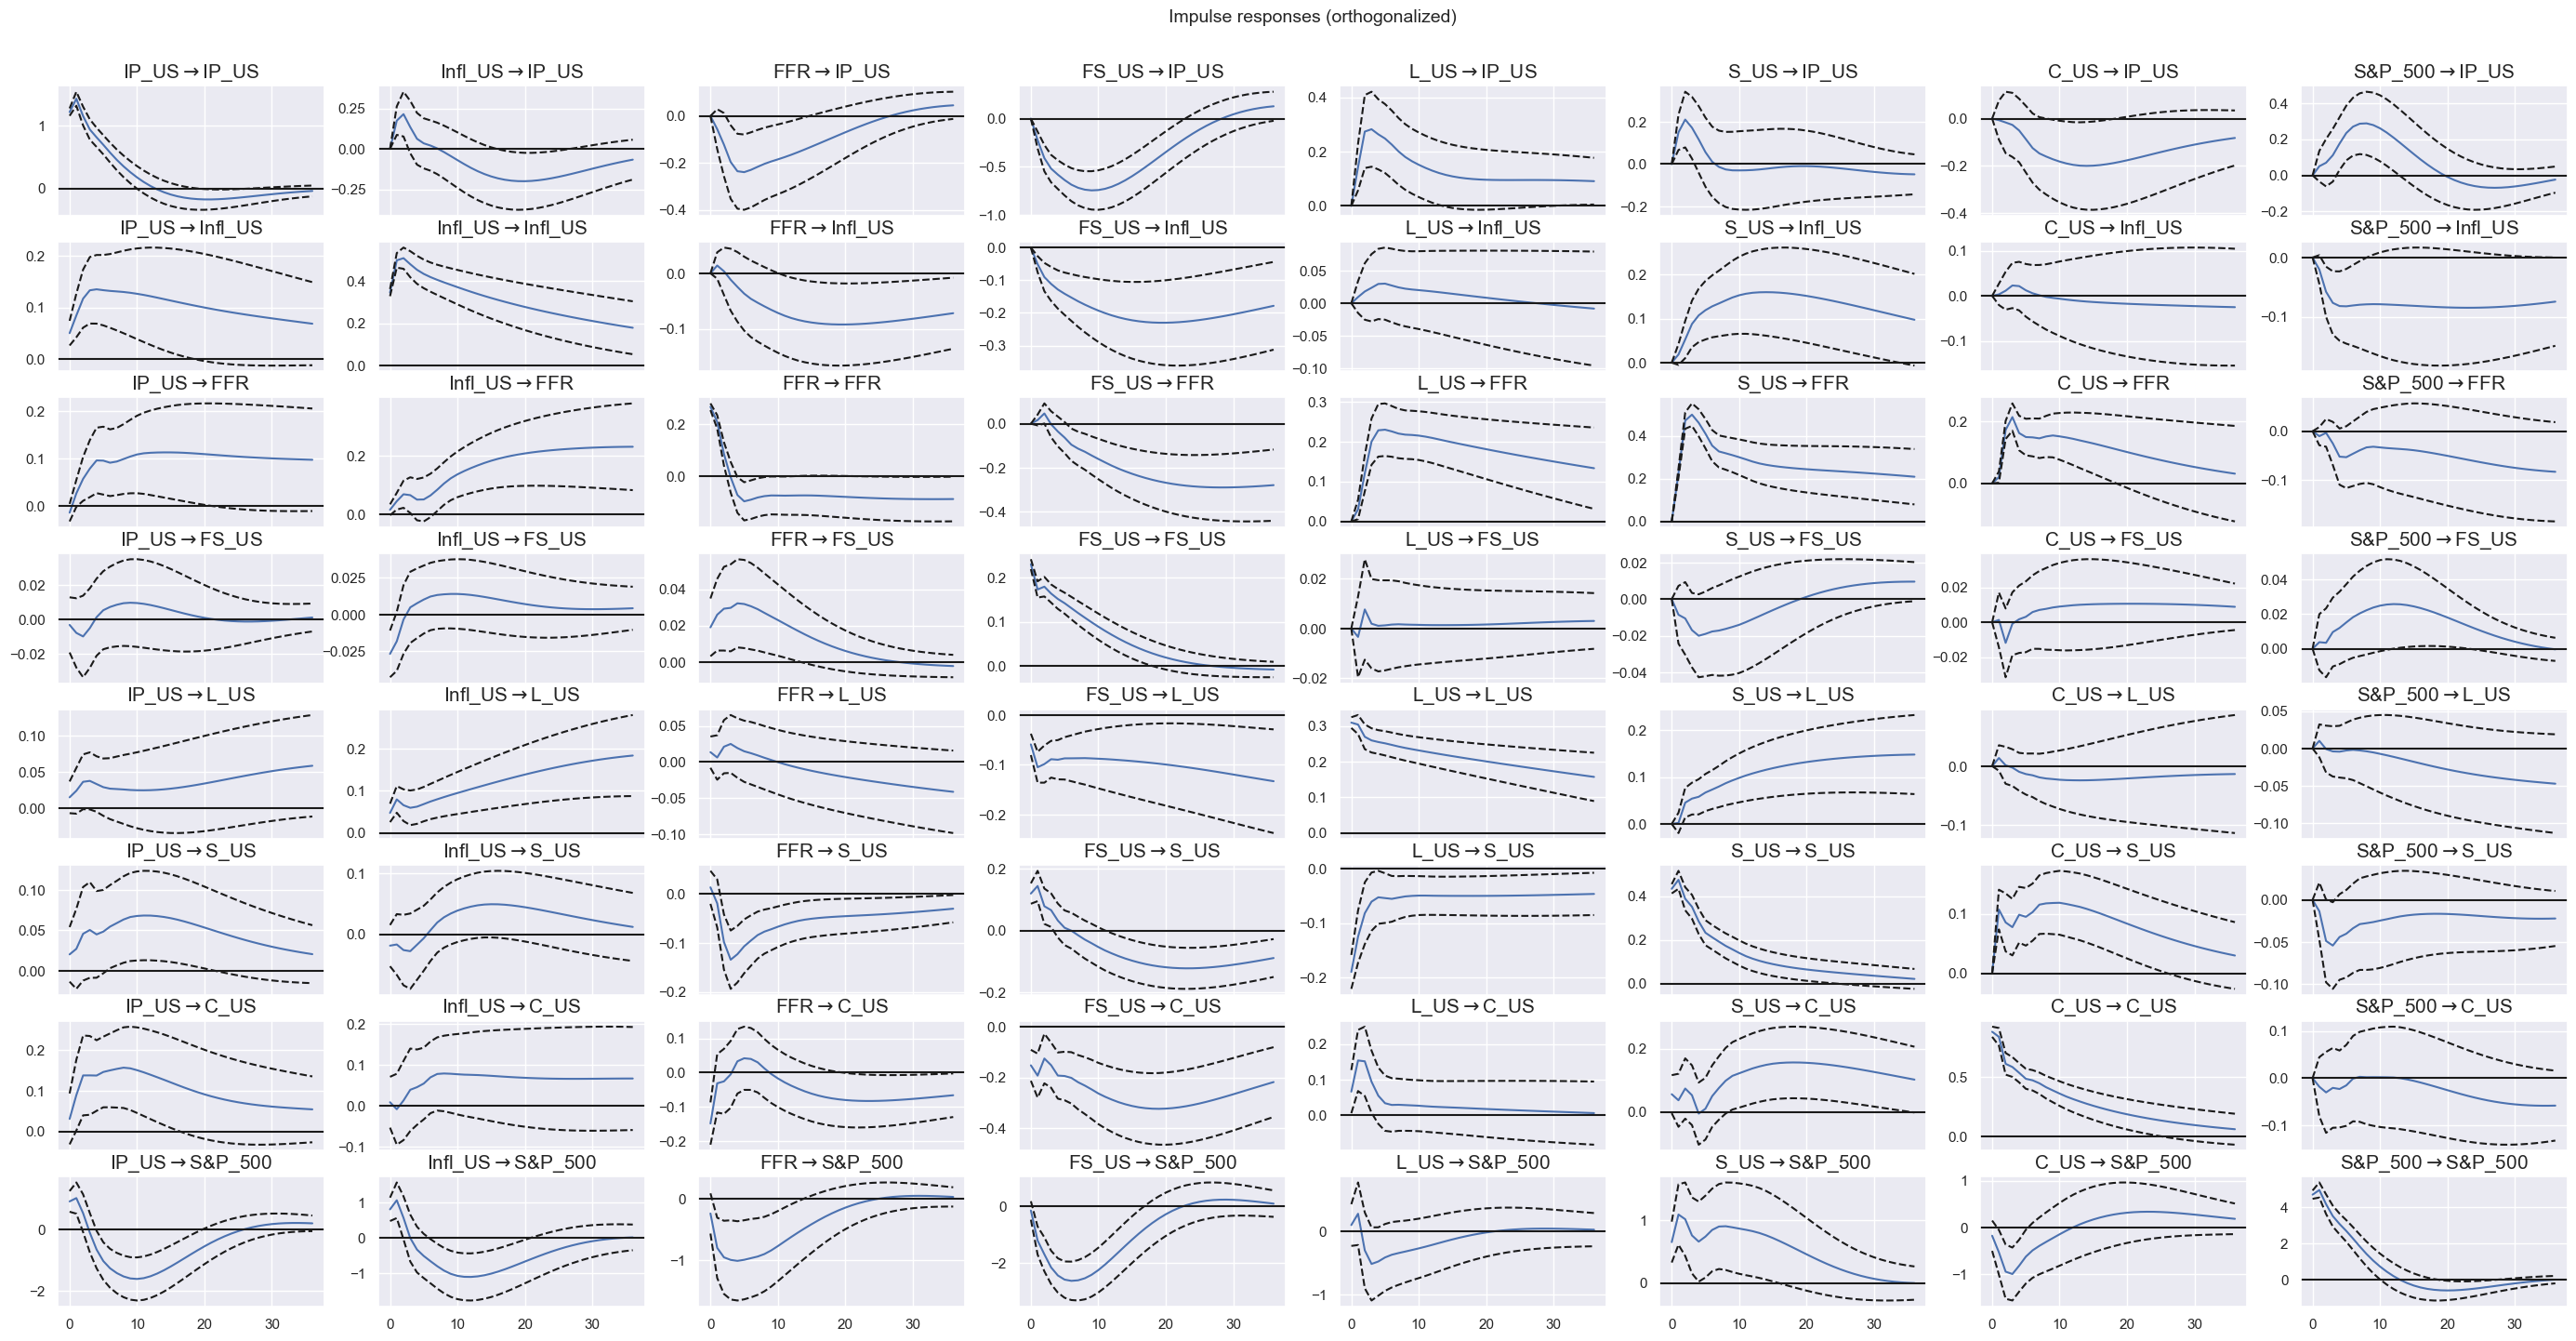

Figure IRF_US_lag_5.pdf has been saved!


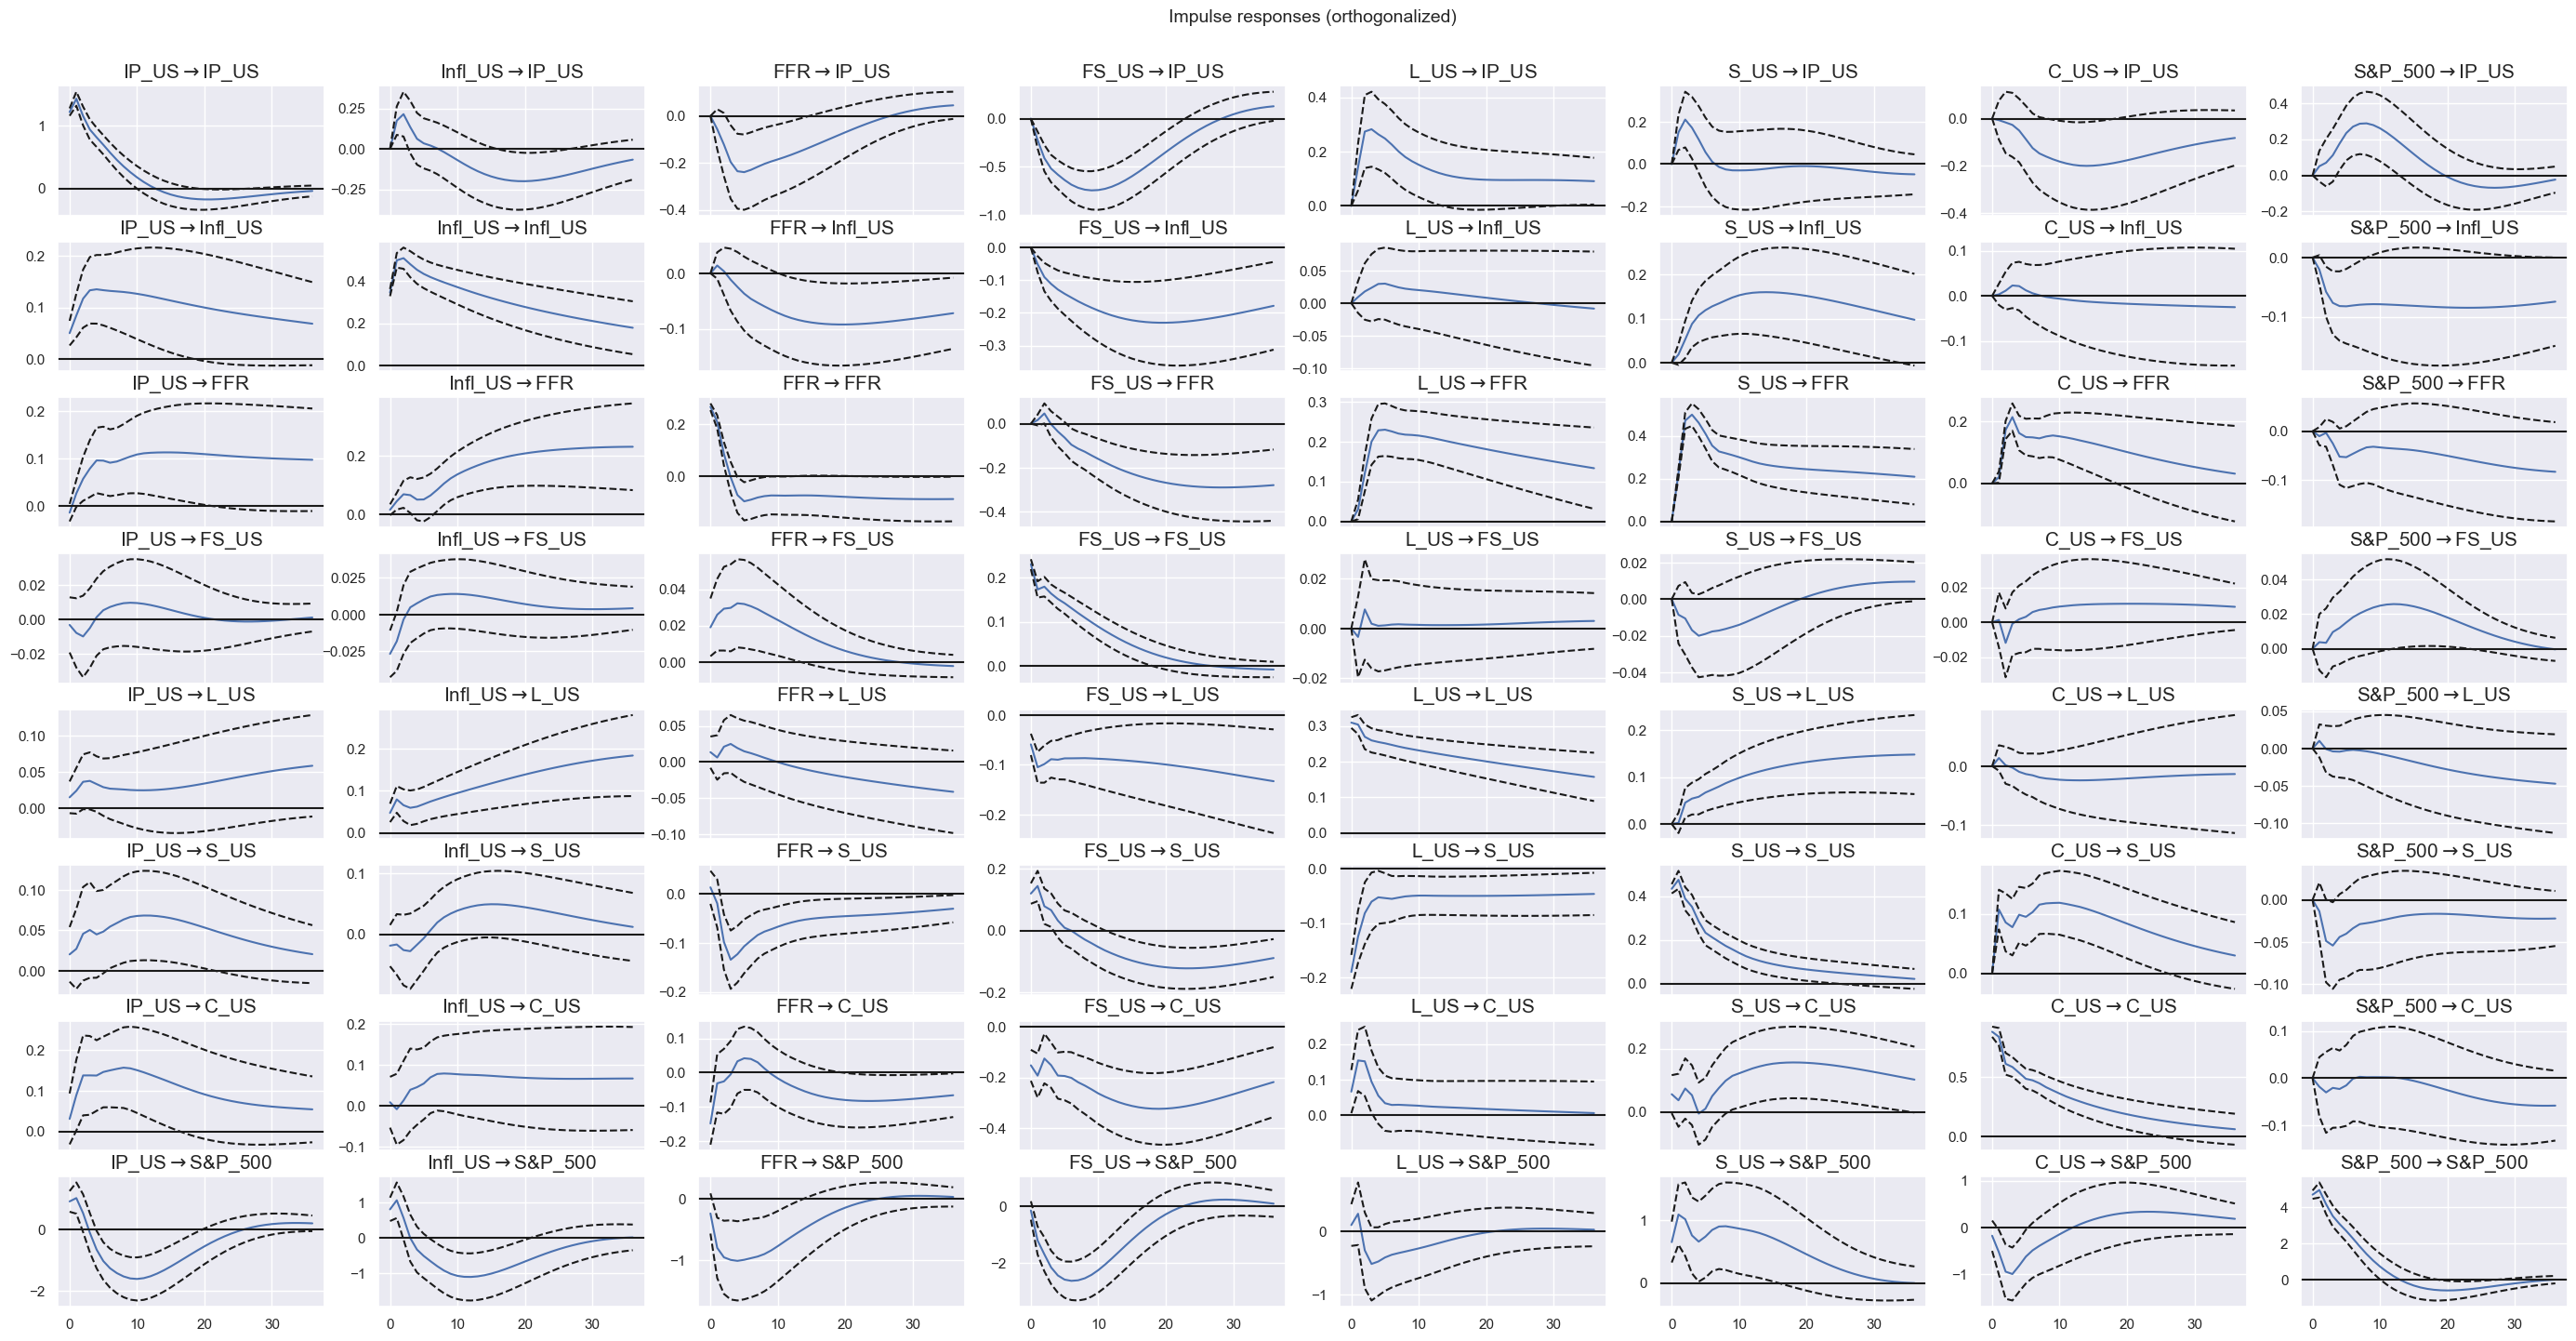

Figure IRF_US_lag_6.pdf has been saved!


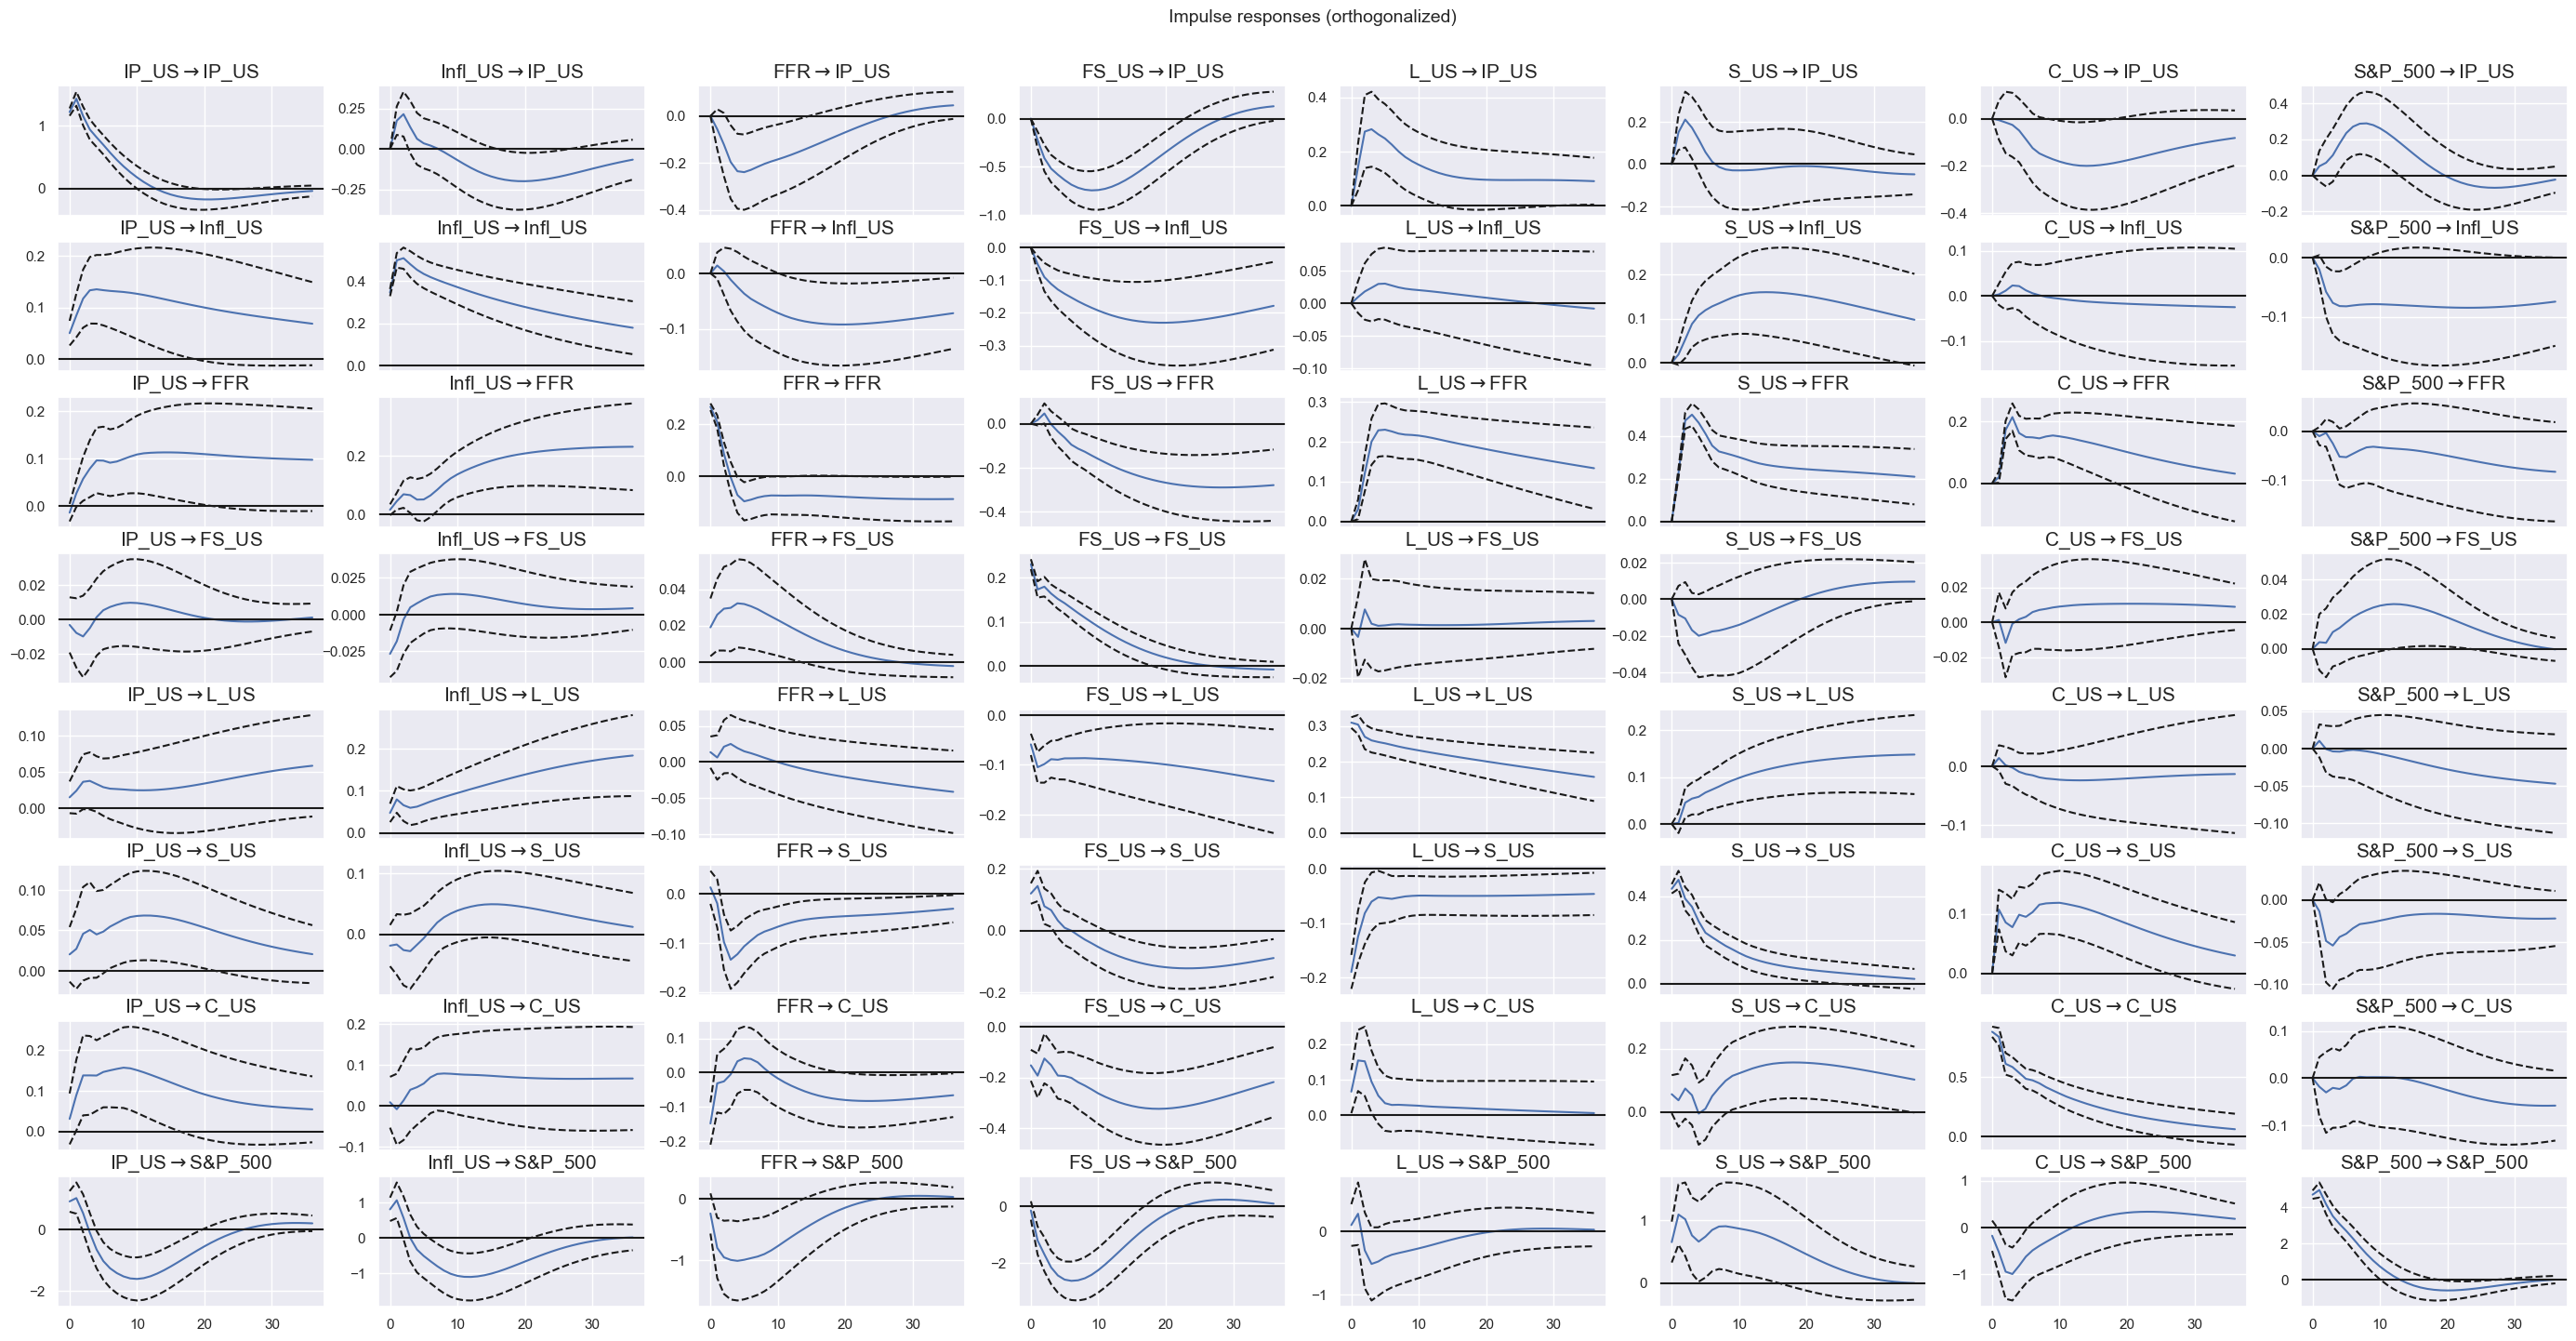

\begin{tabular}{lrrrr}
\toprule
  Lag &  Log-Likelihood &   AIC &   BIC &  HQIC \\
\midrule
$p=1$ &        -4270.06 & -7.55 & -7.00 & -7.33 \\
$p=2$ &        -4072.67 & -7.99 & -6.95 & -7.58 \\
$p=3$ &        -3954.31 & -8.15 & -6.63 & -7.56 \\
$p=4$ &        -3954.31 & -8.15 & -6.63 & -7.56 \\
$p=5$ &        -3954.31 & -8.15 & -6.63 & -7.56 \\
$p=6$ &        -3954.31 & -8.15 & -6.63 & -7.56 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
  Lag &  Log-Likelihood &   AIC &   BIC &  HQIC \\
\midrule
$p=1$ &        -4270.06 & -7.55 & -7.00 & -7.33 \\
$p=2$ &        -4072.67 & -7.99 & -6.95 & -7.58 \\
$p=3$ &        -3954.31 & -8.15 & -6.63 & -7.56 \\
$p=4$ &        -3954.31 & -8.15 & -6.63 & -7.56 \\
$p=5$ &        -3954.31 & -8.15 & -6.63 & -7.56 \\
$p=6$ &        -3954.31 & -8.15 & -6.63 & -7.56 \\
\bottomrule
\end{tabular}



c:\Users\alexa\Documents\Studium\MSc (WU)\Master Thesis\Analysis\Code\MA_functions.py:144: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_ic.to_latex(index=False, escape=False, float_format="%.2f"))
C:\Users\alexa\AppData\Local\Temp\ipykernel_18776\1531942906.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_ic_test.to_latex(index=False, escape=False, float_format="%.2f"))


In [123]:
df_ic_test = get_svars(df_analysis_us, lag_start=1, lag_end=6, geography="US")
print(df_ic_test.to_latex(index=False, escape=False, float_format="%.2f"))

## Grange Causality Tests

Chosen Model

In [122]:
# Estimate sVAR
model_us = VAR(df_analysis_us)
print(model_us.select_order())

result = model_us.fit(maxlags=6, ic="aic")

# print(result.test_whiteness())
print(result.is_stable())

residuals = result.sigma_u
resid_chol_decomp = np.linalg.cholesky(residuals).astype(np.float64)

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 17, BIC -> 1, FPE -> 17, HQIC ->  2>
True


In [124]:
llf_us = {"Log-Likelihood": result.llf}
aic_us = {"AIC": result.aic}
bic_us = {"BIC": result.bic}
hqic_us = {"HQIC": result.hqic}

dict_ic_us = {**llf_us, **aic_us, **bic_us, **hqic_us}
print(pd.DataFrame.from_dict(dict_ic_us, orient="index").round(4).to_latex())


\begin{tabular}{lr}
\toprule
{} &          0 \\
\midrule
Log-Likelihood & -3954.3057 \\
AIC            &    -8.1520 \\
BIC            &    -6.6293 \\
HQIC           &    -7.5580 \\
\bottomrule
\end{tabular}



C:\Users\alexa\AppData\Local\Temp\ipykernel_18776\1940486351.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(dict_ic_us, orient="index").round(4).to_latex())


### Macro To Yield Curve

In [119]:
# Block Granger Causality
# Macro to Yield Curve
granger_result = result.test_causality(
    ["L_US", "S_US", "C_US"], ["IP_US", "Infl_US", "FFR"], kind="wald"
)

# print(granger_result.summary())

result_macro_us = granger_result.summary()

df_result_macro_us = pd.DataFrame(result_macro_us[1:], columns=result_macro_us[0])

df_result_macro_us.iloc[0, 1]

print(df_result_macro_us.to_latex())

\begin{tabular}{lllll}
\toprule
{} &     Test statistic &      Critical value &                p-value &  df \\
\midrule
0 &  78.37779099857889 &  40.113272069413625 &  6.635216625842672e-07 &  27 \\
\bottomrule
\end{tabular}



C:\Users\alexa\AppData\Local\Temp\ipykernel_18776\3773339749.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_result_macro_us.to_latex())


### Yield Curve to Macro

In [120]:
# Yield Curve to Macro
granger_result = result.test_causality(
    ["IP_US", "Infl_US", "FFR"], ["L_US", "S_US", "C_US"], kind="wald"
)

# print(granger_result.summary())

result_yc_us = granger_result.summary()

df_result_yc_us = pd.DataFrame(result_yc_us[1:], columns=result_yc_us[0])

print(df_result_yc_us.to_latex())

\begin{tabular}{lllll}
\toprule
{} &      Test statistic &      Critical value &                 p-value &  df \\
\midrule
0 &  1129.6180858024702 &  40.113272069413625 &  7.618822467917976e-221 &  27 \\
\bottomrule
\end{tabular}



C:\Users\alexa\AppData\Local\Temp\ipykernel_18776\1331245647.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_result_yc_us.to_latex())
